In [1]:
%cd ..

/home/sasha/effective-inference


## Import libs

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch

#from progressbar import progressbar
from tqdm.auto import tqdm
from collections import defaultdict
from utils.prepare_dataset import load_datasets, cut_datasets

## Define hyperparams

In [3]:
# Define datasets
#['mrpc', 'sst2', 'cola', 'rte', 'qnli']
glue_classification = {'mrpc': ['sentence1', 'sentence2']} #, 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
model = AutoModel.from_pretrained(model_name)
model.eval()

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


model.to(device)
DEBUG_FLAG = True
CUT_SIZE = None if not DEBUG_FLAG else 500

## Load datasets

In [12]:
glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), CUT_SIZE)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

## Collect dataset for layers and heads

In [13]:
import numpy as np
import json
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

In [14]:
def get_dataset_for_regression(prob_of_take=0.13, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    length = len(glue_datasets['mrpc']['train']) if not CUT_SIZE else CUT_SIZE
    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        encoded_inputs = tokenizer.encode(
                            ex['sentence1'],
                            ex['sentence2'],
                            truncation=True,
                            return_tensors='pt'
                        )
        special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
        with h5py.File(f'notebooks/mrpc/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:

            current_hidden_states = f['current_hidden_states'][()]
            next_hidden_states = f['next_hidden_states'][()]
            attentions = f['attentions'][()]

            len_of_seq = attentions.shape[0]
            for from_ in range(len_of_seq):
                for to_ in range(len_of_seq):
                    if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.5:
                        feature_vector = []
                        # (pos form, pos to, is_from_special_token, is_to_special_token,
                        # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)


                        feature_vector.append(from_) # from_ pos
                        feature_vector.append(to_) # to_ pos

                        is_from_special_token = int(from_ in special_symbols)
                        is_to_special_token = int(to_ in special_symbols)
                        feature_vector.append(is_from_special_token)
                        feature_vector.append(is_to_special_token)

                        feature_vector.append(len_of_seq)
                        feature_vector.append(1/len_of_seq)
                        feature_vector.append(from_/len_of_seq)
                        feature_vector.append(to_/len_of_seq)
                        feature_vector.append(len_of_seq - from_)
                        feature_vector.append(len_of_seq - to_)
                        feature_vector += list(current_hidden_states[to_])
                        feature_vector += list(current_hidden_states[from_])


                        if ex_idx < length*0.85:
                            X_train.append(feature_vector)
                            y_train.append(attentions[from_, to_])
                        else:
                            X_test.append(feature_vector)
                            y_test.append(attentions[from_, to_])
    return X_train, y_train, X_test, y_test

In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, max_error, mean_absolute_percentage_error
from statistics import mean

def learn(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, feature_names, num_examples = 1):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) # .reshape(-1, 1)
    y_test_scaled = y_scaler(y_test) # .reshape(-1, 1)
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(y_test_scaled, label='Test scaled distribution')
    plt.title('Target distribution')
    plt.plot()

    print('Y train mean:', np.mean(y_train_scaled))
    print('Y test mean:', np.mean(y_test_scaled))

    print('Mean cross val R2:', np.mean(cross_val_score(model, X_train, y_train_scaled, cv=5, scoring='r2')))

    model.fit(X_train, y_train_scaled)
    preds_scaled = model.predict(X_test)
    preds = reverse_scaler(preds_scaled)
    
    data['r2'] = r2_score(y_test, preds)
    data['mse'] = mean_squared_error(y_test, preds)
    data['explained_variance_score'] = explained_variance_score(y_test, preds)
    data['max_error'] = max_error(y_test, preds)
    data['mean_absolute_percentage_error'] = mean_absolute_percentage_error(y_test, preds)
    metrics.loc[len(metrics)] = data
    
    print(f"Test R2: {data['r2']}; Test MSE:  {data['mse']}; Test explained_variance_score: {data['explained_variance_score']}")
    print(f"Test max_error: {data['max_error']}; Test mean_absolute_percentage_error:  {data['mean_absolute_percentage_error']}")
    print('\nPredictions:')
    samples = np.random.choice(len(X_test), size=num_examples, replace=False)
    for i in samples:
        print(f'Pred = {preds_scaled[i]} / {preds[i]} and target = {y_test_scaled[i]} / {y_test[i]}')

    # Scatter plot of predictions vs. actual values
    plt.subplot(1, 3, 2)
    ax[1].scatter(y_test, preds)
    ax[1].set_xlabel('Actual Values')
    ax[1].set_ylabel('Predictions')
    ax[1].set_title('Predictions vs. Actual Values')

    feature_importance = [abs(el) for el in model[1].coef_]
    most_important_features = np.argsort(feature_importance)[:14]
    fnames = np.array(feature_names)[most_important_features]
    fimport = np.array(feature_importance)[most_important_features]
    #print(fnames, fimport)
    plt.subplot(1, 3, 3)
    ax[2].bar(fnames, fimport)
    ax[2].set_xlabel('Features')
    ax[2].set_ylabel('Importance')
    ax[2].set_title('Feature Importance')
    ax[2].set_xticks(fnames)
    ax[2].set_xticklabels(fnames, rotation=90)

    plt.tight_layout()
    plt.show()


    return model

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), ('lin', Ridge())])
dataset_name = "mrpc"

In [17]:
id_scaler = lambda x: [el for el in x]
log_scaler = lambda x: np.log(x * 1000 + 1)
log_reverse = lambda x: (np.exp(x) - 1) / 1000

In [10]:
import pandas as pd
import datetime
cols = ['layer', 'head', 'model_name', 'features', 'r2', 'mse', 'explained_variance_score', 'max_error', 
                                     'mean_absolute_percentage_error']
metrics = pd.read_csv(f"linear_metrics_report{datetime.date.today()}.csv", index_col = [0])
metrics

,layer,head,model_name,features,r2,mse,explained_variance_score,max_error,mean_absolute_percentage_error
0,0,0,Ridge,pos,0.172172,0.000107,0.172172,0.148808,0.661201
1,0,0,Ridge,"emb_from, pos",0.165723,0.000108,0.165723,0.150373,0.666732
2,0,0,Ridge,"emb_to, pos",0.352989,0.000084,0.352990,0.133115,0.530736
3,0,0,Ridge,"emb_to, emb_from, pos",0.348483,0.000085,0.348483,0.134830,0.532953
4,0,0,Ridge,"emb_to, pos, st_to, st_from",0.352907,0.000084,0.352907,0.133132,0.530607
...,...,...,...,...,...,...,...,...,...
107,3,3,Ridge,"emb_to, emb_from, pos",0.212829,0.002183,0.212831,0.663660,182.586712
108,3,3,Ridge,"emb_to, pos, st_to, st_from",0.216701,0.002173,0.216703,0.671449,184.520906
109,3,3,Ridge,"pos, st_to, st_from",0.206591,0.002201,0.206593,0.688581,222.411287
110,3,3,Ridge,"pos, poly",0.009105,0.002748,0.009107,0.684101,328.561267


## Layer 0

In [182]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=0, head_num=3)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
data = {i: '' for i in cols}
data['layer'] = 0
data['head'] = 3
data['model_name'] = 'Ridge'
X_train.shape, X_test.shape

500it [01:30,  5.55it/s]


((167309, 1546), (29109, 1546))

### Ex

Only embeddings from

Y train mean: 0.01773356
Y test mean: 0.01776802
Mean cross val R2: -0.0016253731318350395
Test R2: 0.01770074591338977; Test MSE:  0.00013430528362659217; Test explained_variance_score: 0.01770946173195942
Test max_error: 0.19607688087724512; Test mean_absolute_percentage_error:  0.7562075590483531

Predictions:
Pred = 0.014673771468921296 / 0.014673771468921296 and target = 0.013845883309841156 / 0.013845883309841156


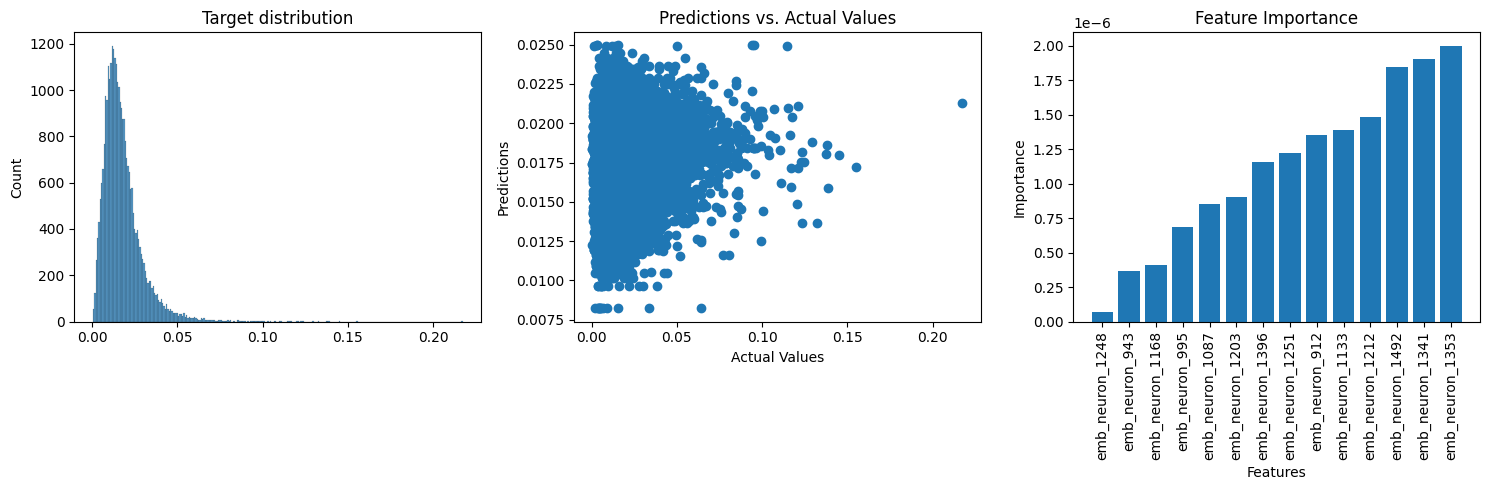

Success


In [50]:
feature_names = [f'emb_neuron_{i}' for i in range(778,1546)]

lst_features =  list( range(778,1546))
data['features'] = 'emb_from'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

Only embeddings to

Y train mean: 0.01773356
Y test mean: 0.01776802
Mean cross val R2: 0.21544546619479807
Test R2: 0.22994923130758127; Test MSE:  0.00010528551911838447; Test explained_variance_score: 0.22995794050479978
Test max_error: 0.18923499885777886; Test mean_absolute_percentage_error:  0.6096025680398443

Predictions:
Pred = 0.025917824099064124 / 0.025917824099064124 and target = 0.04404684156179428 / 0.04404684156179428


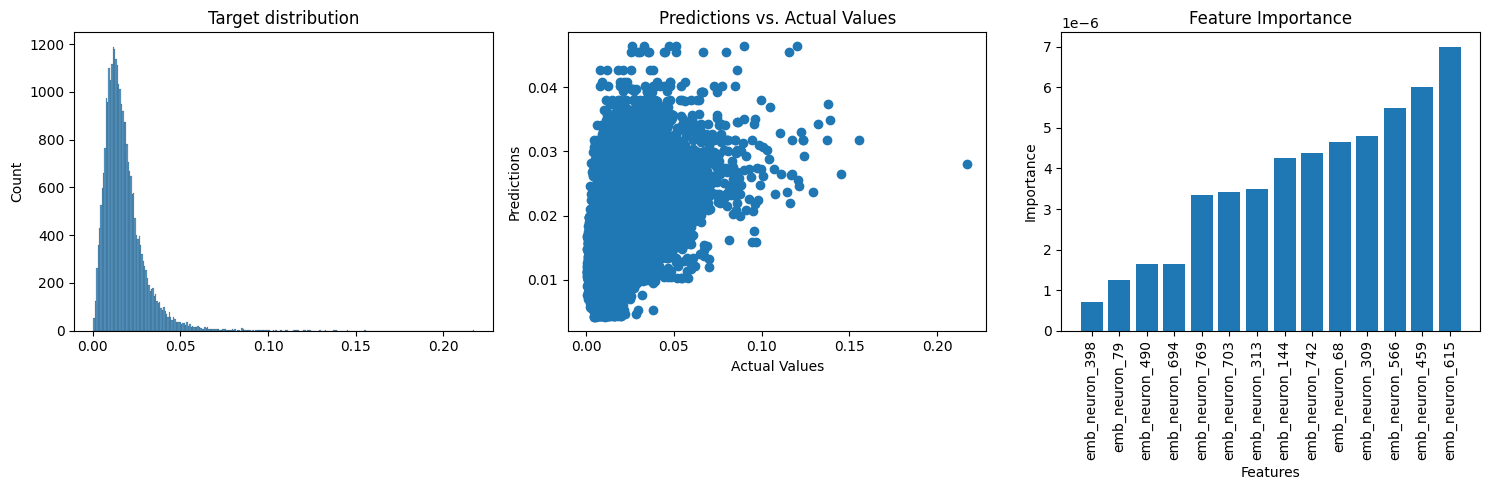

Success


In [51]:
feature_names = [f'emb_neuron_{i}' for i in range(10,778)]

lst_features =  list( range(10,778))
data['features'] = 'emb_to'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Only Position Features

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: 0.0042702665211965755
Test R2: 0.005443348027059147; Test MSE:  0.0051900802181413025; Test explained_variance_score: 0.005443357023525164
Test max_error: 0.9049504502429824; Test mean_absolute_percentage_error:  206.48392382058833

Predictions:
Pred = 0.019044243973408703 / 0.019044243973408703 and target = 0.0007689976482652128 / 0.0007689976482652128


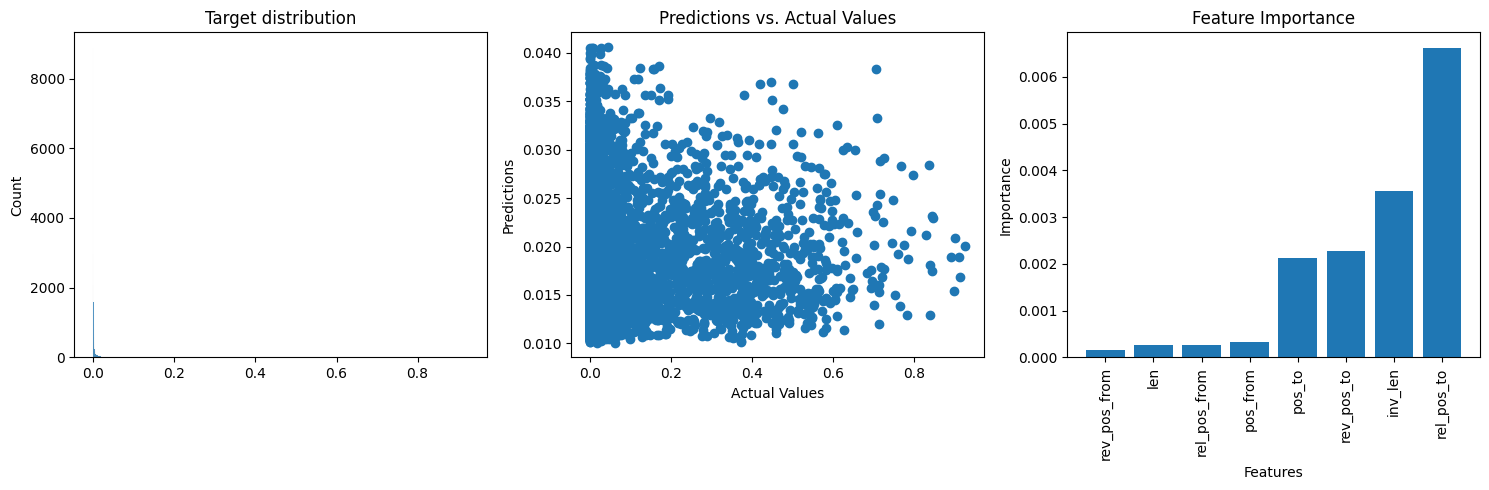

Success


In [319]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb From

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: -0.0009404556503908257
Test R2: 0.0007232495548067375; Test MSE:  0.0052147119871410064; Test explained_variance_score: 0.000723258593421261
Test max_error: 0.9056120030341871; Test mean_absolute_percentage_error:  208.80728914187713

Predictions:
Pred = 0.011895713916547538 / 0.011895713916547538 and target = 0.0006333120982162654 / 0.0006333120982162654


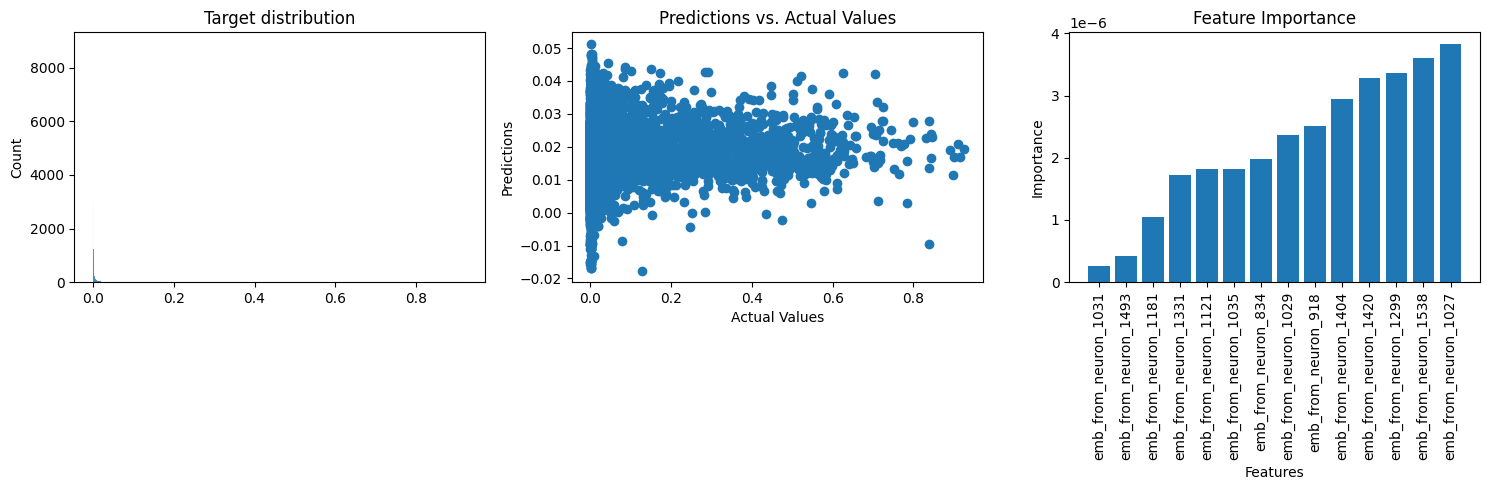

Success


In [320]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(778,1546))
data['features'] = 'emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb To

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: 0.005102314486764658
Test R2: 0.00851164988225861; Test MSE:  0.0051740683270837485; Test explained_variance_score: 0.008511658851325432
Test max_error: 0.8903374566296669; Test mean_absolute_percentage_error:  185.66656622664593

Predictions:
Pred = 0.00847545261304188 / 0.00847545261304188 and target = 3.496059434837662e-05 / 3.496059434837662e-05


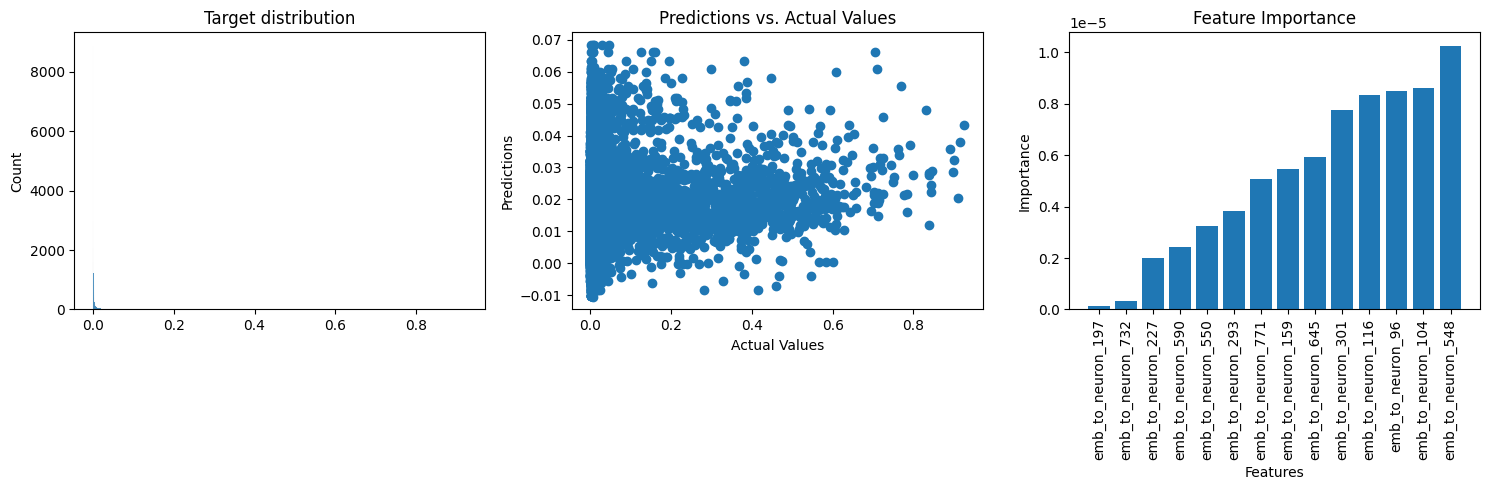

Success


In [321]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions Emb To and Emb From

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: -0.00021140495666613913
Test R2: 0.00359237741824725; Test MSE:  0.0051997394828218; Test explained_variance_score: 0.003592386431241601
Test max_error: 0.8879087632231051; Test mean_absolute_percentage_error:  190.5334729002406

Predictions:
Pred = 0.003982386626616976 / 0.003982386626616976 and target = 0.00040784760494716465 / 0.00040784760494716465


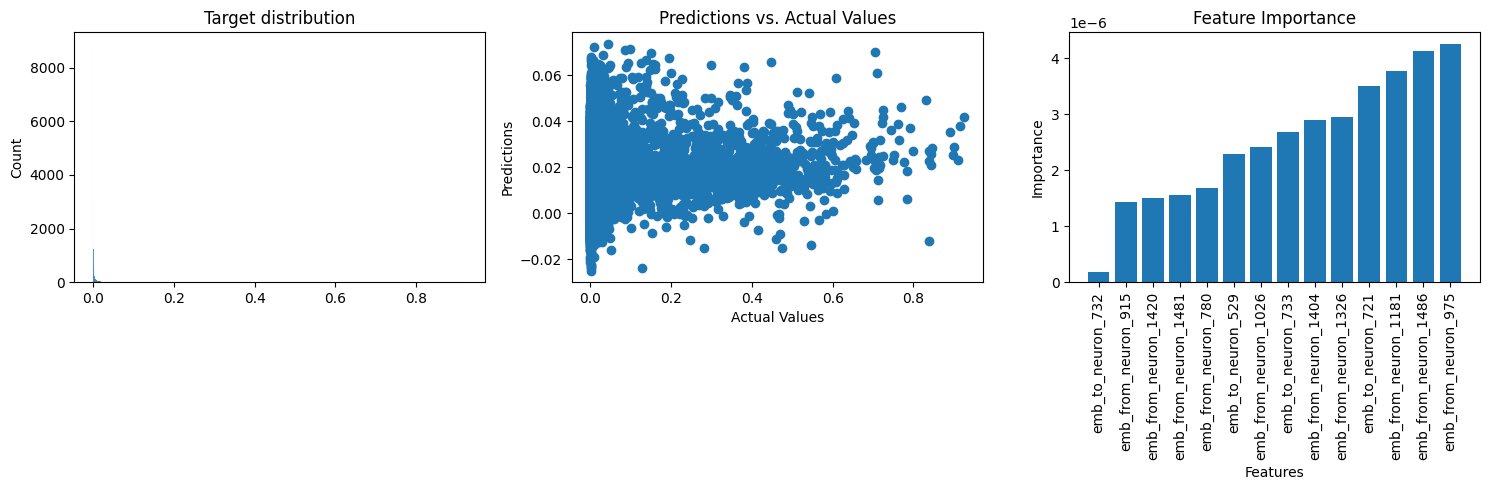

Success


In [322]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]+[f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,1546))
data['features'] = 'emb_to, emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions, Emb To, Special Symbols

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: 0.005116714226805397
Test R2: 0.00851844921705136; Test MSE:  0.005174032844848589; Test explained_variance_score: 0.008518458186057676
Test max_error: 0.8906072785305237; Test mean_absolute_percentage_error:  186.10574741942276

Predictions:
Pred = 0.01936267186805653 / 0.01936267186805653 and target = 0.0021695755422115326 / 0.0021695755422115326


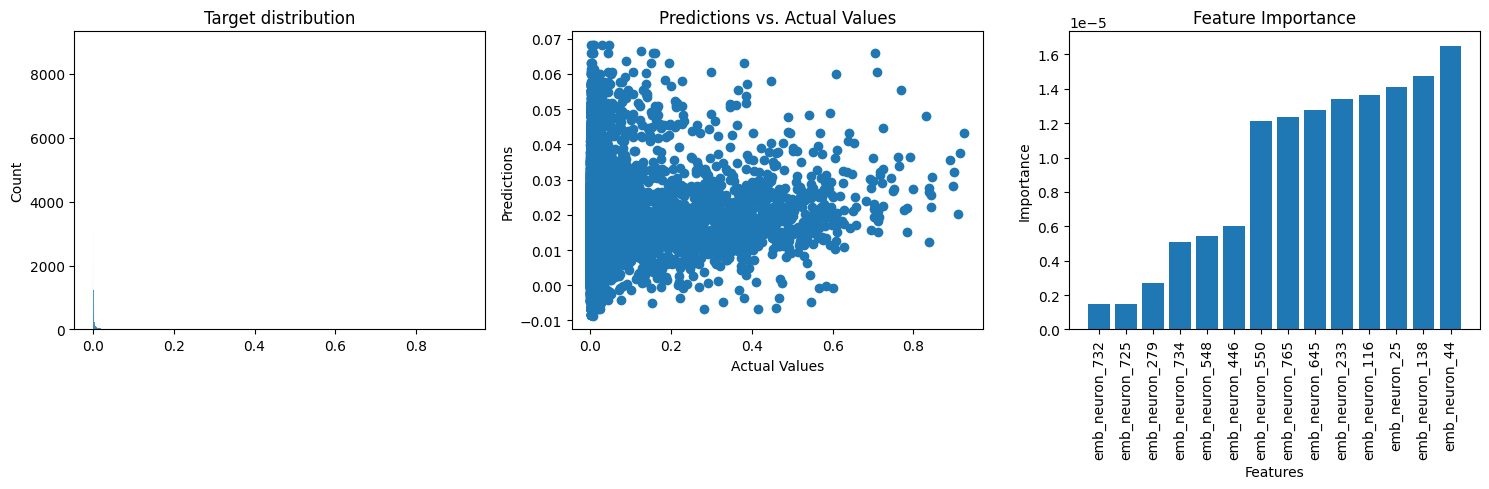

Success


In [323]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]
 
lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos, st_to, st_from'

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
print('Success')

### Positions and Special Symbols

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: 0.0049391611502518805
Test R2: 0.006289998854713041; Test MSE:  0.005185661982434405; Test explained_variance_score: 0.00629000784361855
Test max_error: 0.9053888893807941; Test mean_absolute_percentage_error:  207.6094721489552

Predictions:
Pred = 0.015617504589250417 / 0.015617504589250417 and target = 0.013675155118107796 / 0.013675155118107796


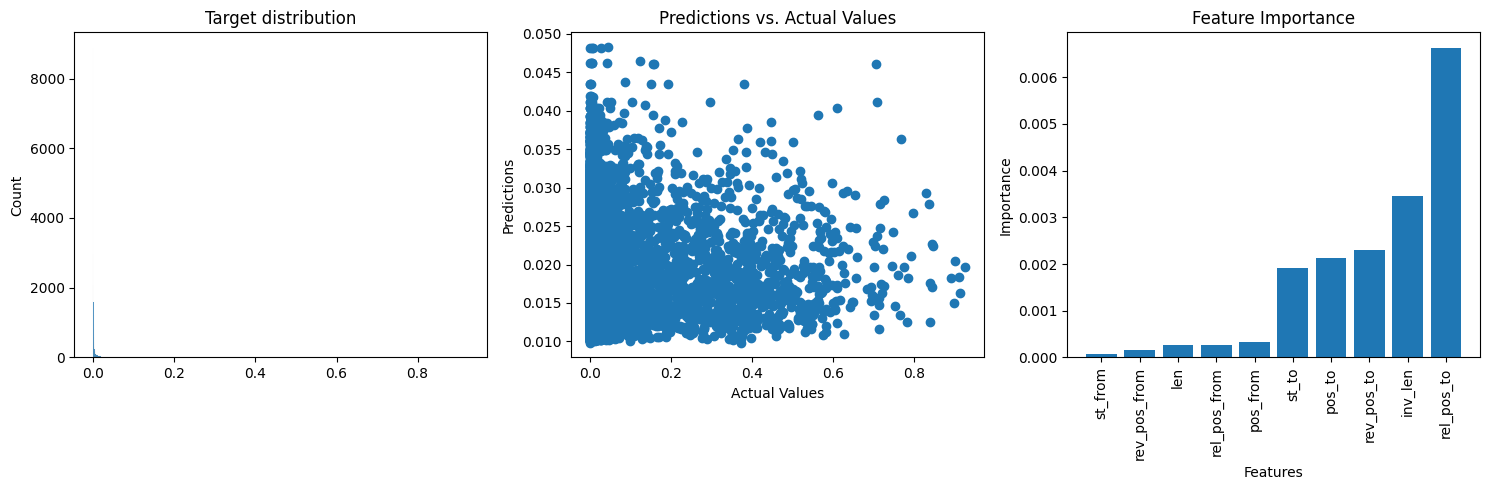

Success


In [324]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos, st_to, st_from'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Polynomial

Y train mean: 0.0175689
Y test mean: 0.017569678
Mean cross val R2: 0.0042702665211965755
Test R2: 0.005443348027059147; Test MSE:  0.0051900802181413025; Test explained_variance_score: 0.005443357023525164
Test max_error: 0.9049504502429824; Test mean_absolute_percentage_error:  206.48392382058833

Predictions:
Pred = 0.012897391763464813 / 0.012897391763464813 and target = 2.3142547433963045e-05 / 2.3142547433963045e-05


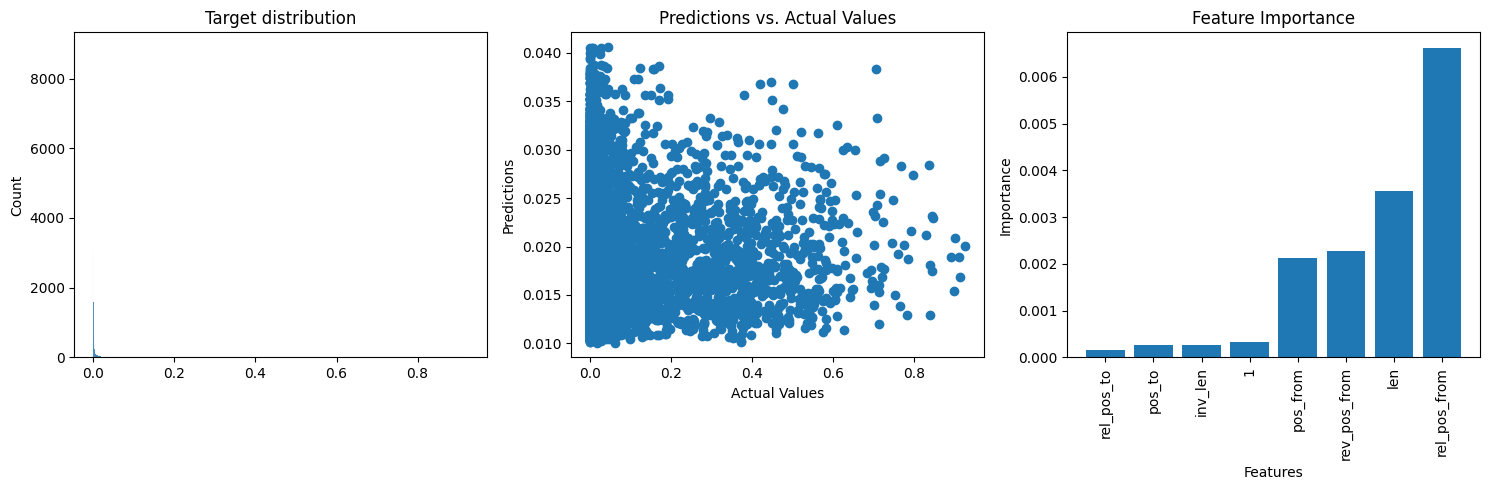

Success


In [325]:
data['features'] = 'pos, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ALL TOGETHER

Y train mean: 0.017764037
Y test mean: 0.017564086
Mean cross val R2: 0.32356674564125526
Test R2: 0.34713424333480236; Test MSE:  8.603911896566317e-05; Test explained_variance_score: 0.34739664200577736
Test max_error: 0.23880288222711832; Test mean_absolute_percentage_error:  0.5409723188614949

Predictions:
Pred = 0.029464463714824363 / 0.029464463714824363 and target = 0.03973094001412392 / 0.03973094001412392


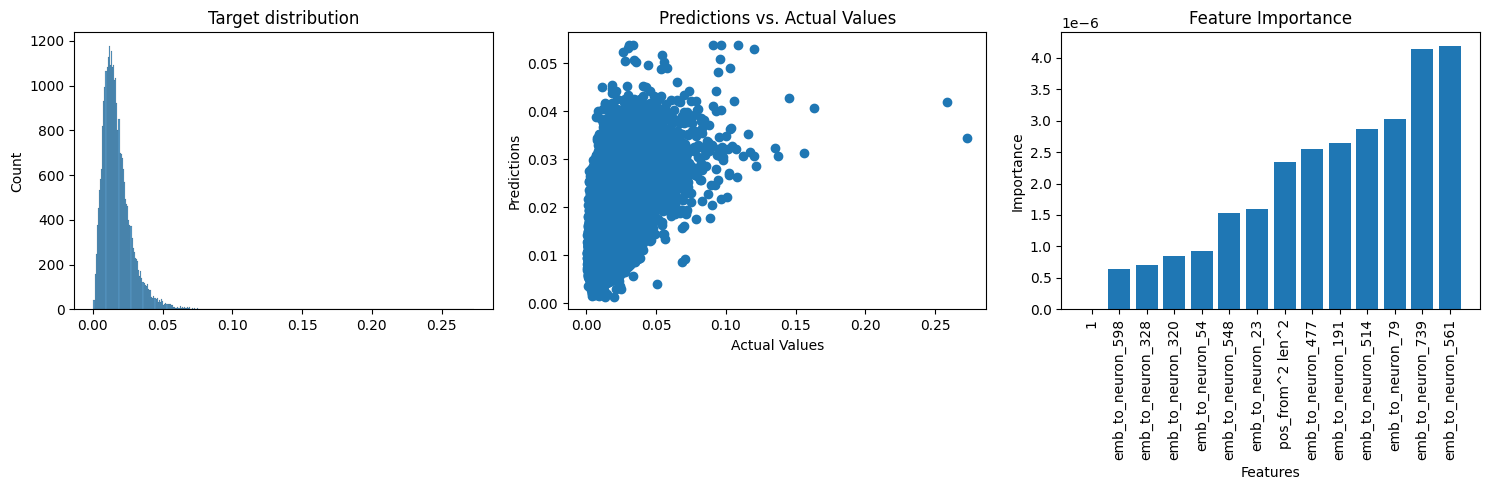

Success


In [174]:
data['features'] = 'emb_to, pos, st_to, st_from, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]
    
lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
    
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)
    
feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_to_neuron_{i}' for i in range(10,778)]
    
learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [327]:
metrics.to_csv(f'linear_metrics_report{datetime.date.today()}.csv')

## Layer 3

In [328]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=3, head_num=3)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
data = {i: '' for i in cols}
data['layer'] = 3
data['head'] = 3
data['model_name'] = 'Ridge'
X_train.shape, X_test.shape

500it [01:33,  5.34it/s]


((166183, 1546), (29228, 1546))

In [329]:
metrics

,layer,head,model_name,features,r2,mse,explained_variance_score,max_error,mean_absolute_percentage_error
0,0,0,Ridge,pos,0.172172,0.000107,0.172172,0.148808,0.661201
1,0,0,Ridge,"emb_from, pos",0.165723,0.000108,0.165723,0.150373,0.666732
2,0,0,Ridge,"emb_to, pos",0.352989,0.000084,0.352990,0.133115,0.530736
3,0,0,Ridge,"emb_to, emb_from, pos",0.348483,0.000085,0.348483,0.134830,0.532953
4,0,0,Ridge,"emb_to, pos, st_to, st_from",0.352907,0.000084,0.352907,0.133132,0.530607
...,...,...,...,...,...,...,...,...,...
99,0,3,Ridge,"emb_to, emb_from, pos",0.003592,0.005200,0.003592,0.887909,190.533473
100,0,3,Ridge,"emb_to, pos, st_to, st_from",0.008518,0.005174,0.008518,0.890607,186.105747
101,0,3,Ridge,"pos, st_to, st_from",0.006290,0.005186,0.006290,0.905389,207.609472
102,0,3,Ridge,"pos, poly",0.005443,0.005190,0.005443,0.904950,206.483924


### Only Position Features

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.007444883919965384
Test R2: 0.009105273269674252; Test MSE:  0.002748495284969725; Test explained_variance_score: 0.009107150655933705
Test max_error: 0.6841010454848386; Test mean_absolute_percentage_error:  328.56126728079187

Predictions:
Pred = 0.018669891993049935 / 0.018669891993049935 and target = 0.005740444641560316 / 0.005740444641560316


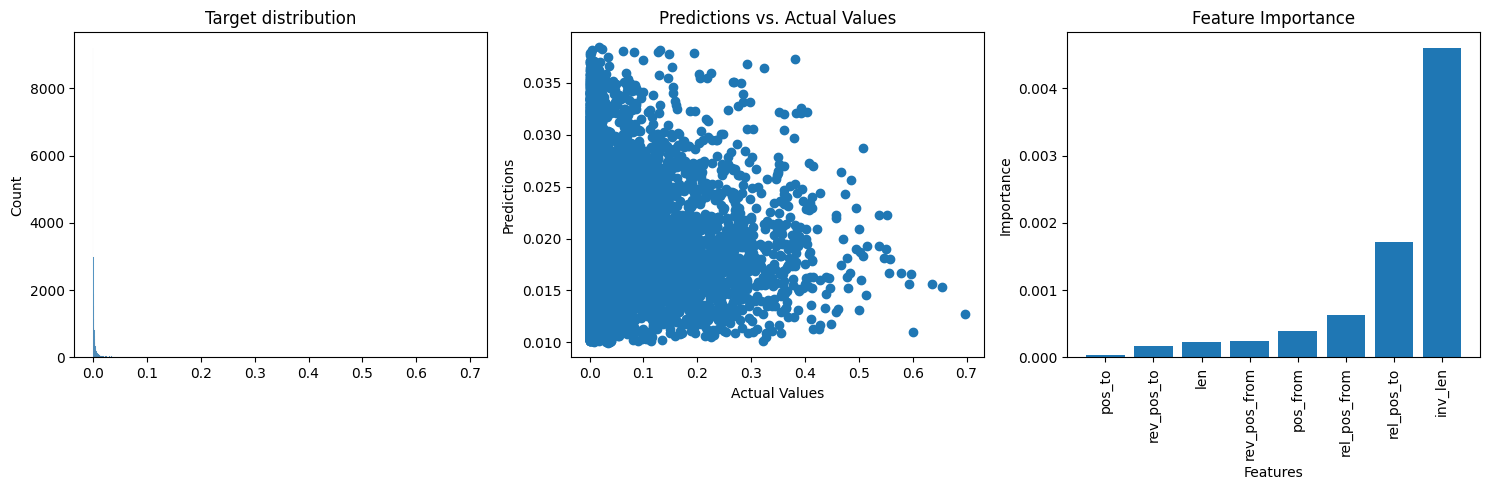

Success


In [330]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb From

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.002128855519172701
Test R2: 0.004784492121773676; Test MSE:  0.002760480056199235; Test explained_variance_score: 0.0047863694968643955
Test max_error: 0.6812428597224535; Test mean_absolute_percentage_error:  325.63094597724506

Predictions:
Pred = 0.014753986891594843 / 0.014753986891594843 and target = 0.00018382912094239146 / 0.00018382912094239146


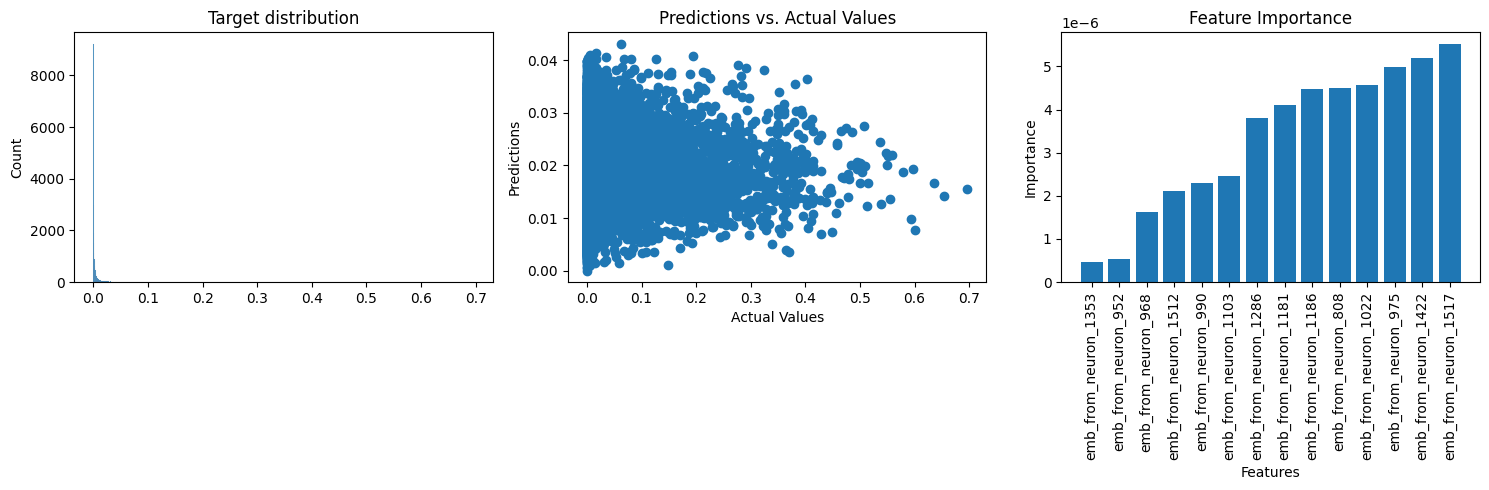

Success


In [331]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(778,1546))
data['features'] = 'emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb To

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.21664252604001302
Test R2: 0.21529416042571703; Test MSE:  0.002176578643500132; Test explained_variance_score: 0.2152960383449417
Test max_error: 0.6667251163400565; Test mean_absolute_percentage_error:  176.92017369915553

Predictions:
Pred = 0.00808213997816831 / 0.00808213997816831 and target = 0.002318732440471649 / 0.002318732440471649


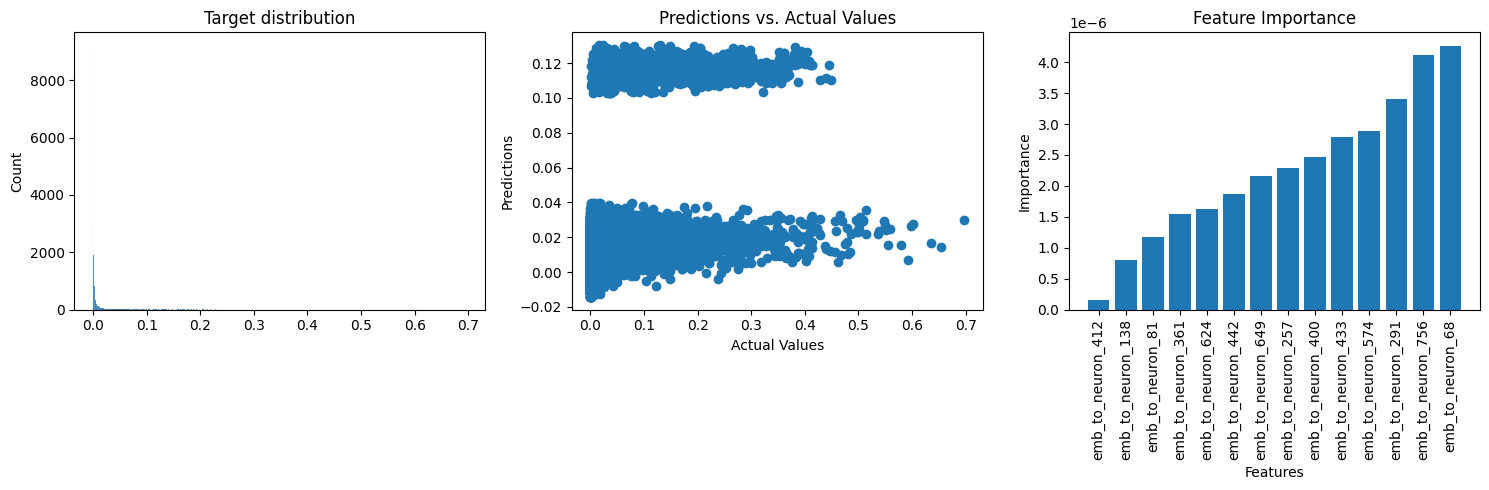

Success


In [332]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions Emb To and Emb From

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.21243219082438483
Test R2: 0.21282873292974125; Test MSE:  0.0021834171255964933; Test explained_variance_score: 0.21283061084259303
Test max_error: 0.663659563607703; Test mean_absolute_percentage_error:  182.5867123423956

Predictions:
Pred = 0.006963418167665443 / 0.006963418167665443 and target = 0.0008510991465300322 / 0.0008510991465300322


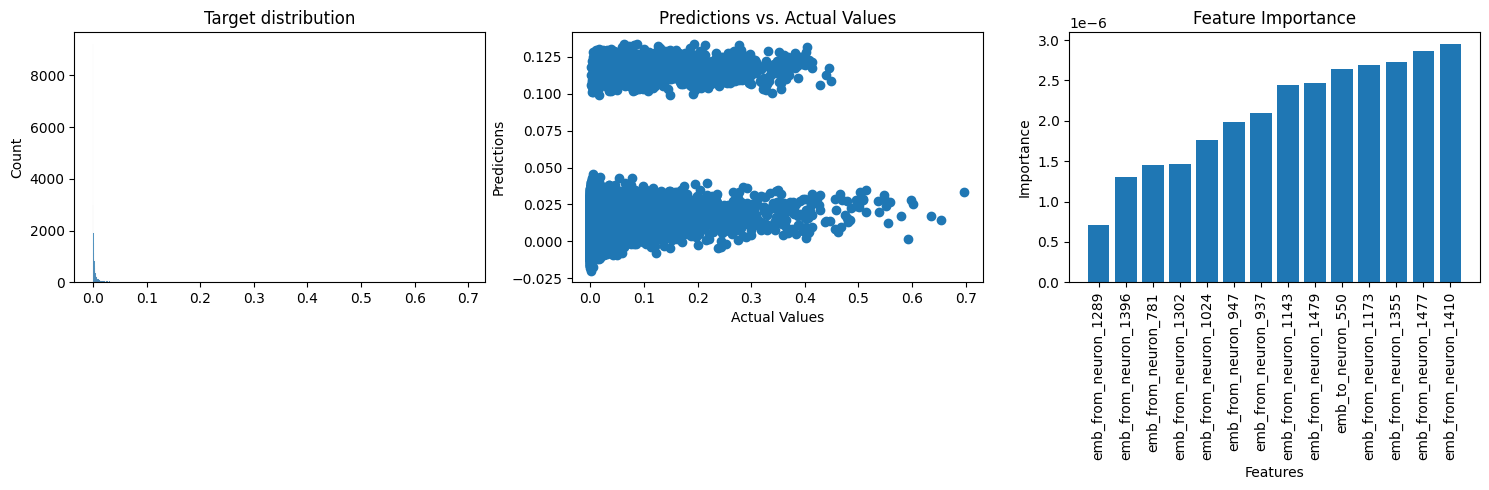

Success


In [333]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]+[f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,1546))
data['features'] = 'emb_to, emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions, Emb To, Special Symbols

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.21834004952437072
Test R2: 0.2167008567884301; Test MSE:  0.002172676817992332; Test explained_variance_score: 0.21670273471129098
Test max_error: 0.6714492566143445; Test mean_absolute_percentage_error:  184.52090586559714

Predictions:
Pred = 0.019232303678170356 / 0.019232303678170356 and target = 0.00108071428257972 / 0.00108071428257972


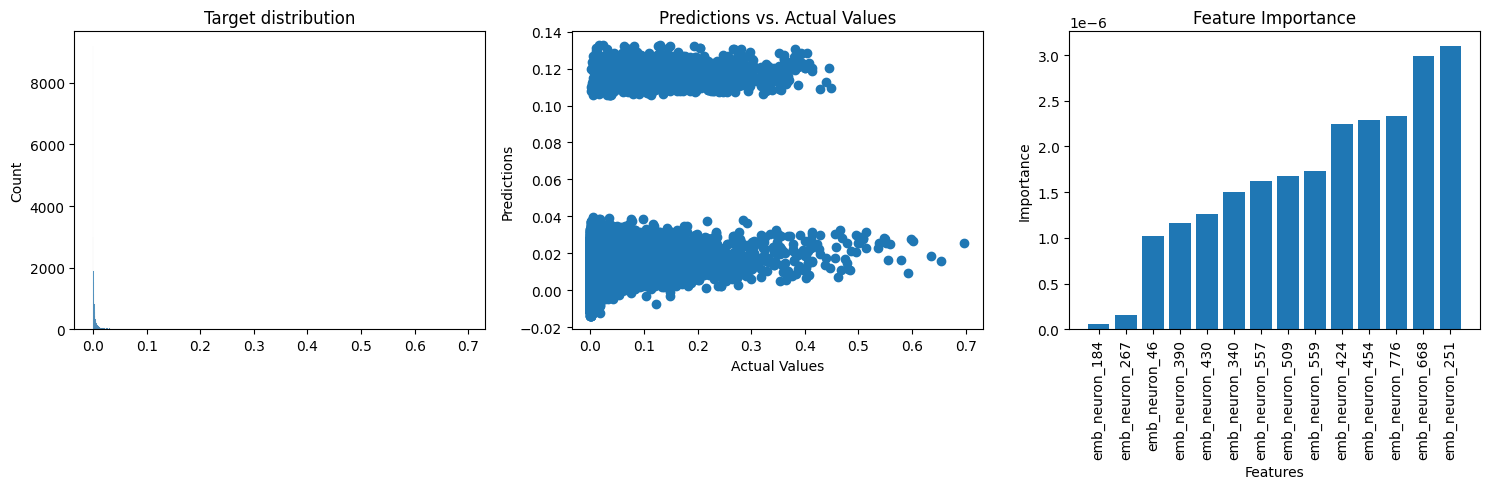

Success


In [334]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]
 
lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos, st_to, st_from'

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
print('Success')

### Positions and Special Symbols

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.20690958925214692
Test R2: 0.20659109291320144; Test MSE:  0.002200718786118362; Test explained_variance_score: 0.20659297080993
Test max_error: 0.6885807354534592; Test mean_absolute_percentage_error:  222.41128697732387

Predictions:
Pred = 0.007712879824912335 / 0.007712879824912335 and target = 0.013638745993375778 / 0.013638745993375778


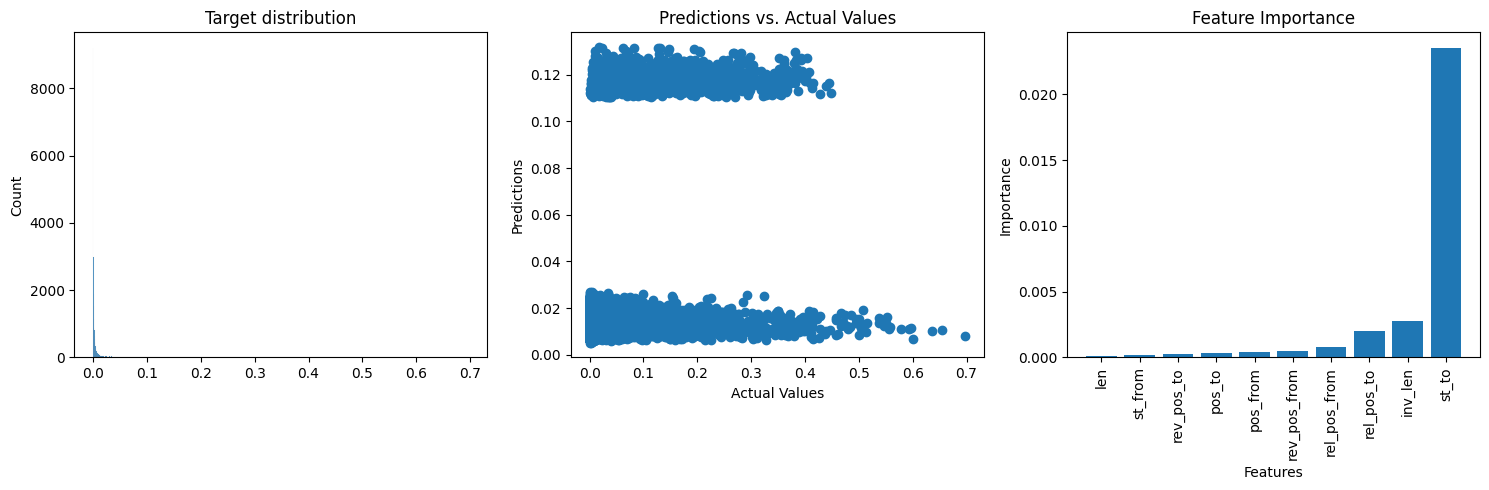

Success


In [335]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos, st_to, st_from'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Polynomial

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.007444883919965384
Test R2: 0.009105273269674252; Test MSE:  0.002748495284969725; Test explained_variance_score: 0.009107150655933705
Test max_error: 0.6841010454848386; Test mean_absolute_percentage_error:  328.56126728079187

Predictions:
Pred = 0.010611100262439294 / 0.010611100262439294 and target = 0.0012500747106969357 / 0.0012500747106969357


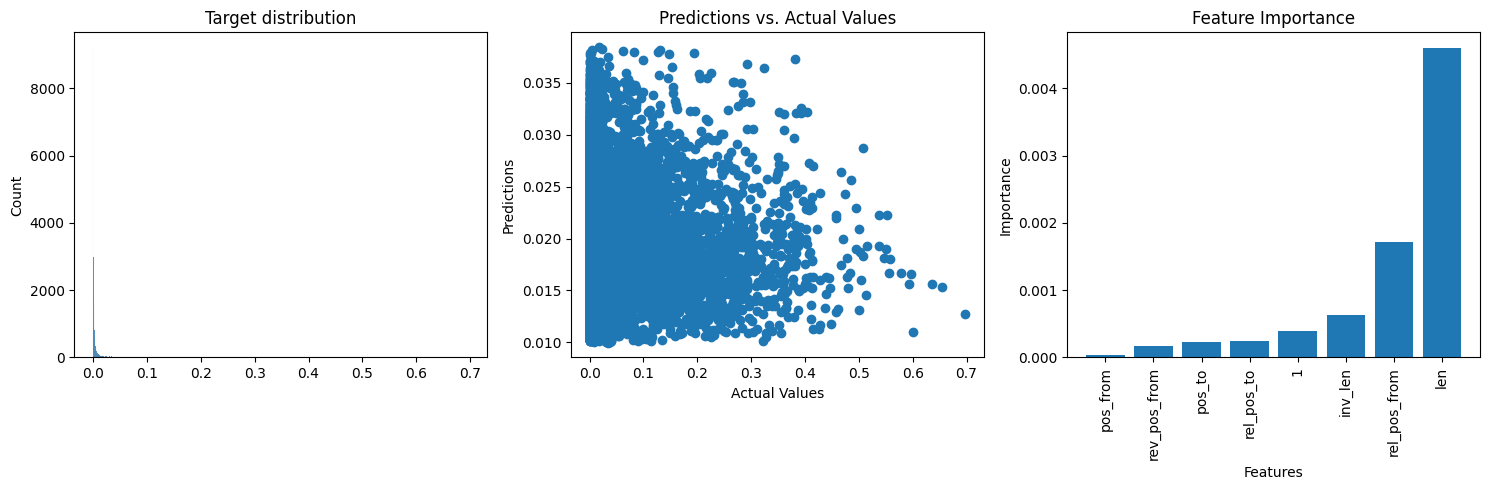

Success


In [336]:
data['features'] = 'pos, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ALL TOGETHER

Y train mean: 0.01784055
Y test mean: 0.01776834
Mean cross val R2: 0.2828796892616307
Test R2: 0.2781642379152832; Test MSE:  0.0020021927002870326; Test explained_variance_score: 0.27816650857841996
Test max_error: 0.6575381348213485; Test mean_absolute_percentage_error:  192.29598799796696

Predictions:
Pred = 0.02850754731225812 / 0.02850754731225812 and target = 0.002422931371256709 / 0.002422931371256709


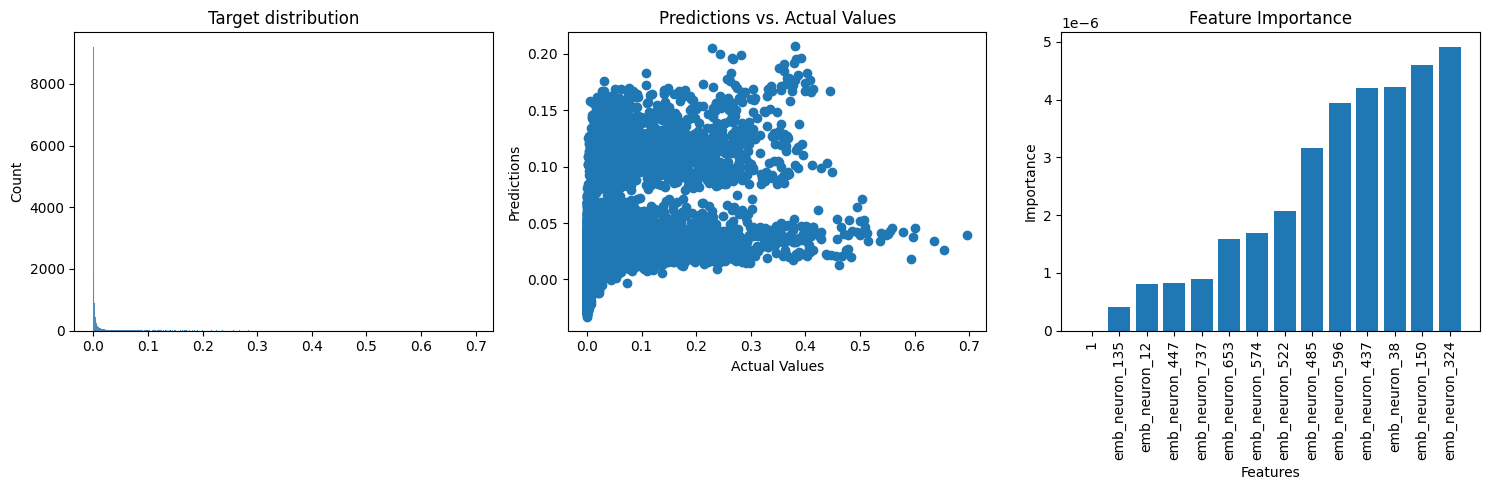

Success


In [337]:
data['features'] = 'emb_to, pos, st_to, st_from, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]
    
lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
    
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)
    
feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
    
learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [347]:
t = metrics[['layer', 'head']]
t.drop_duplicates()


,layer,head
0,0,0
8,3,0
16,7,0
24,11,0
32,0,6
40,3,6
48,7,6
56,11,6
64,0,11
72,3,11


In [339]:
metrics.to_csv(f'linear_metrics_report{datetime.date.today()}.csv')

## Layer 7

In [18]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=7, head_num=3)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
data = {i: '' for i in cols}
data['layer'] = 7
data['head'] = 3
data['model_name'] = 'Ridge'
X_train.shape, X_test.shape

500it [01:32,  5.43it/s]


((166282, 1546), (29283, 1546))

In [29]:
metrics[metrics['layer'] == 7]['head'].unique()

array([ 0,  6, 11,  3])

### Only Position Features

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.029071938378375805
Test R2: 0.030665303489073148; Test MSE:  0.006446028202309603; Test explained_variance_score: 0.03067791021897648
Test max_error: 0.5279593365496009; Test mean_absolute_percentage_error:  1574.3460301468442

Predictions:
Pred = 0.0329181649972323 / 0.0329181649972323 and target = 2.617793325043749e-05 / 2.617793325043749e-05


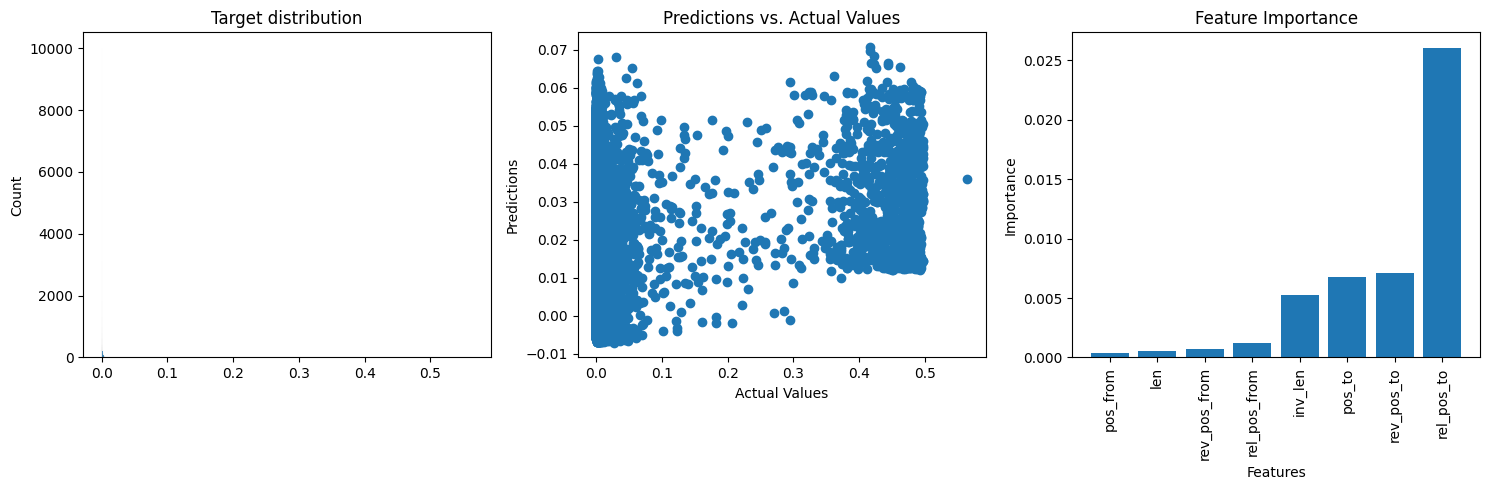

Success


In [20]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb From

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.02403472548843073
Test R2: 0.02579278885874914; Test MSE:  0.006478430185686745; Test explained_variance_score: 0.02580539560181827
Test max_error: 0.5186106112307767; Test mean_absolute_percentage_error:  1660.6326684806745

Predictions:
Pred = 0.0018659782567666226 / 0.0018659782567666226 and target = 6.17954574408941e-05 / 6.17954574408941e-05


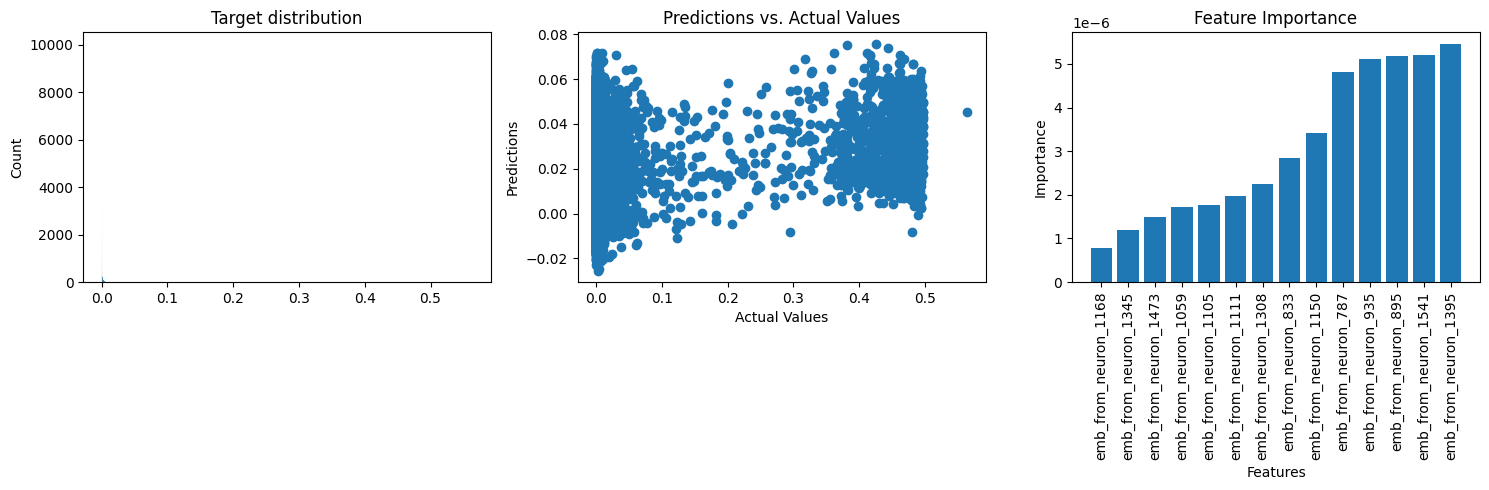

Success


In [21]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(778,1546))
data['features'] = 'emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb To

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.9373632243681346
Test R2: 0.9448213846574935; Test MSE:  0.00036693508644893605; Test explained_variance_score: 0.944833988917305
Test max_error: 0.5599642518760557; Test mean_absolute_percentage_error:  528.2513062228805

Predictions:
Pred = 0.00835719960575915 / 0.00835719960575915 and target = 0.00022877664014231414 / 0.00022877664014231414


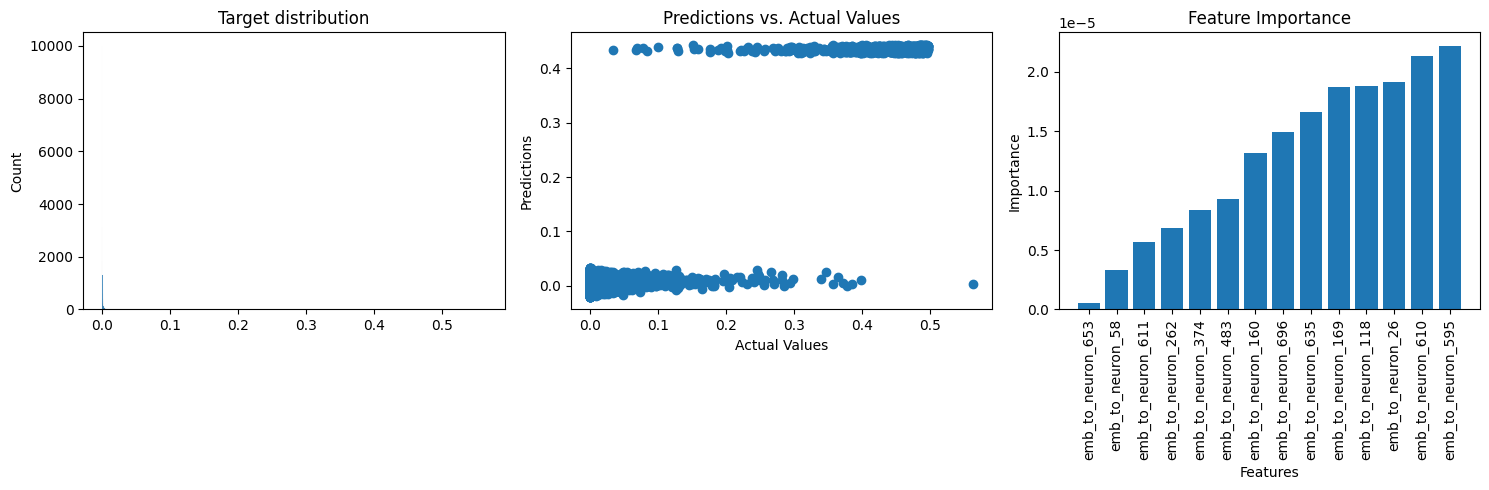

Success


In [22]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions Emb To and Emb From

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.937161851631201
Test R2: 0.9444394114419703; Test MSE:  0.0003694751896028337; Test explained_variance_score: 0.9444520157028139
Test max_error: 0.5612604084007216; Test mean_absolute_percentage_error:  536.2369387671908

Predictions:
Pred = -0.0007212475352748118 / -0.0007212475352748118 and target = 8.053713099798188e-05 / 8.053713099798188e-05


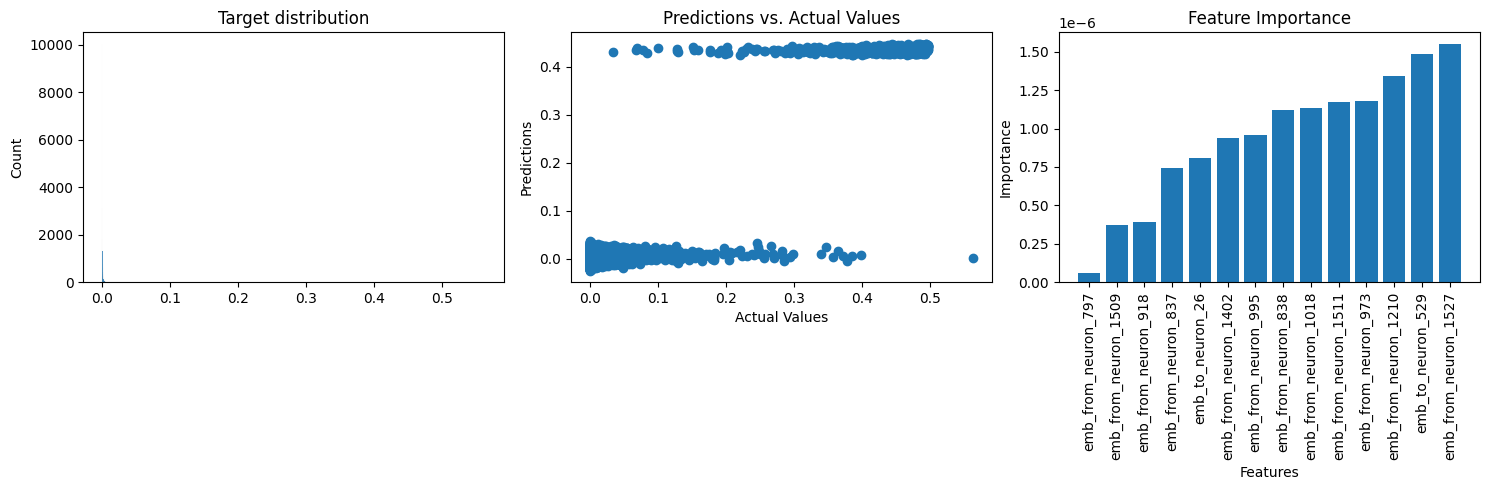

Success


In [23]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]+[f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,1546))
data['features'] = 'emb_to, emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions, Emb To, Special Symbols

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.9390412150231201
Test R2: 0.9463267839118014; Test MSE:  0.0003569242552221859; Test explained_variance_score: 0.9463393881675451
Test max_error: 0.5643341121385433; Test mean_absolute_percentage_error:  432.1946438036656

Predictions:
Pred = -0.0043486094142747254 / -0.0043486094142747254 and target = 2.8166707124910317e-05 / 2.8166707124910317e-05


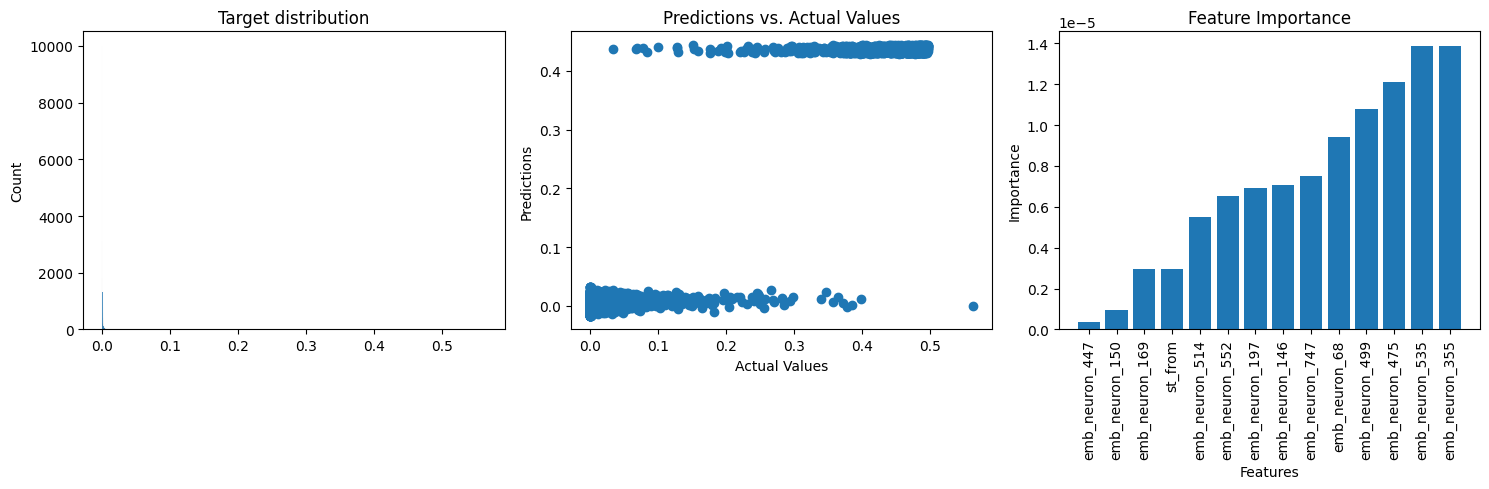

Success


In [24]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]
 
lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos, st_to, st_from'

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
print('Success')

### Positions and Special Symbols

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.6462277787165154
Test R2: 0.6571951349180303; Test MSE:  0.002279635544008824; Test explained_variance_score: 0.6572077399550212
Test max_error: 0.5514500762208773; Test mean_absolute_percentage_error:  1017.6727881892685

Predictions:
Pred = -0.018440054927695054 / -0.018440054927695054 and target = 2.4670576749485917e-05 / 2.4670576749485917e-05


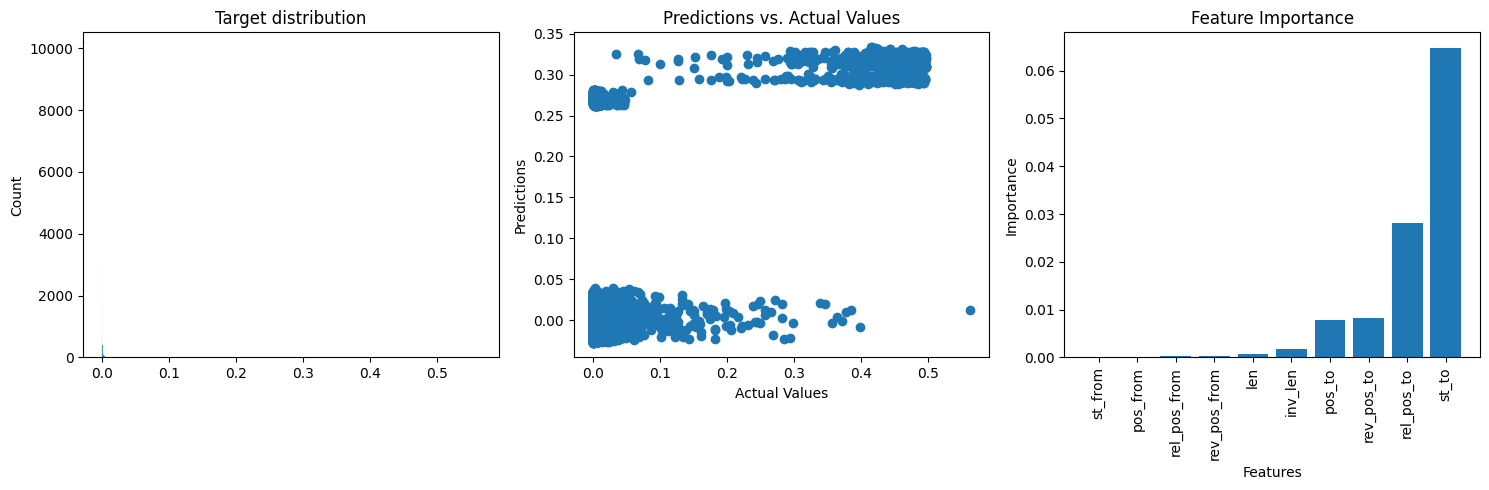

Success


In [25]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos, st_to, st_from'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Polynomial

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.029071938378375805
Test R2: 0.030665303489073148; Test MSE:  0.006446028202309603; Test explained_variance_score: 0.03067791021897648
Test max_error: 0.5279593365496009; Test mean_absolute_percentage_error:  1574.3460301468442

Predictions:
Pred = 0.03303139584254333 / 0.03303139584254333 and target = 0.0036638863384723663 / 0.0036638863384723663


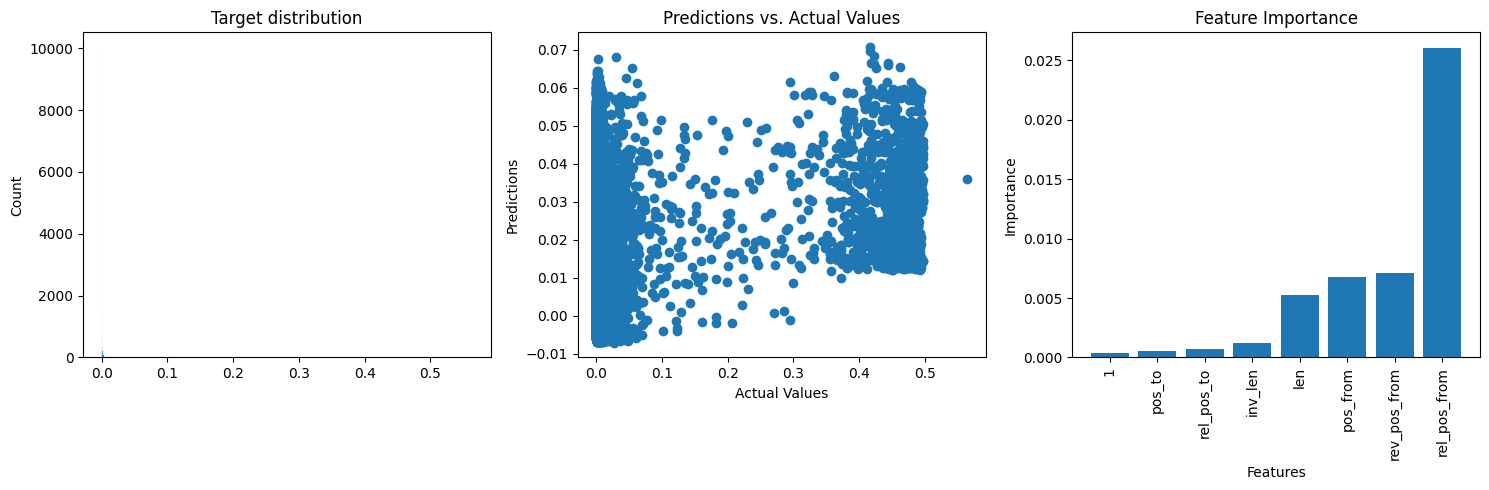

Success


In [26]:
data['features'] = 'pos, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ALL TOGETHER

Y train mean: 0.017863492
Y test mean: 0.01757398
Mean cross val R2: 0.937871577066731
Test R2: 0.945321383212805; Test MSE:  0.0003636101205725951; Test explained_variance_score: 0.9453351676401567
Test max_error: 0.5589144619067179; Test mean_absolute_percentage_error:  557.3045473818488

Predictions:
Pred = -0.011873521757901025 / -0.011873521757901025 and target = 0.00027850037440657616 / 0.00027850037440657616


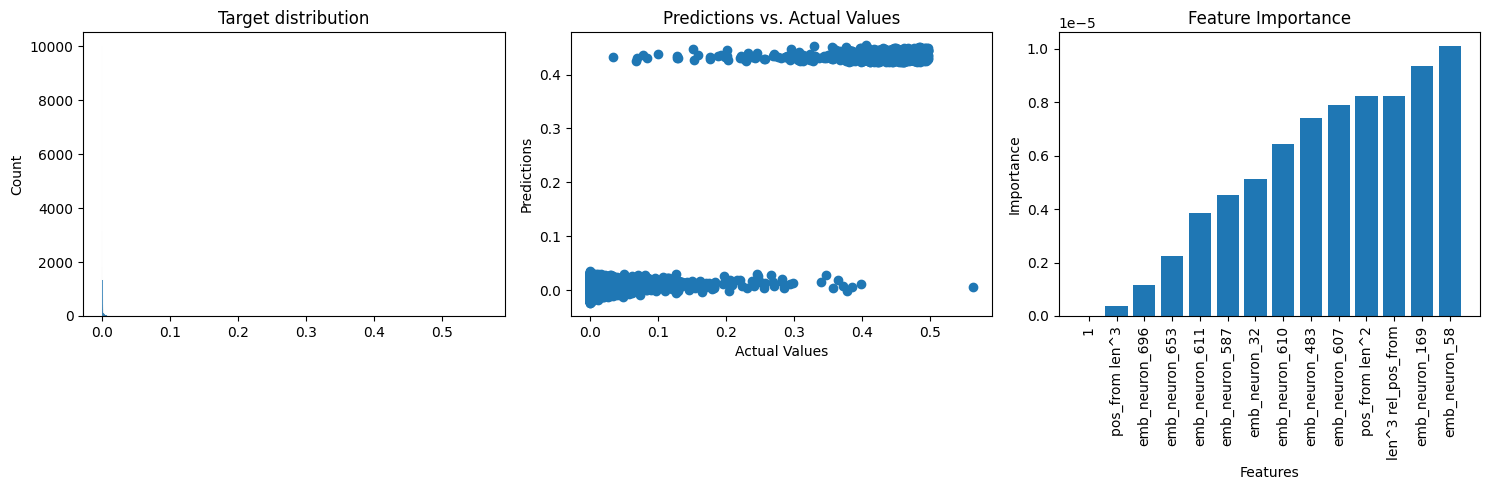

Success


In [27]:
data['features'] = 'emb_to, pos, st_to, st_from, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]
    
lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
    
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)
    
feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
    
learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [28]:
metrics.to_csv(f'linear_metrics_report{datetime.date.today()}.csv')

## Layer 11

In [30]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(layer=11, head_num=3)
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
data = {i: '' for i in cols}
data['layer'] = 11
data['head'] = 3
data['model_name'] = 'Ridge'
X_train.shape, X_test.shape

500it [01:32,  5.41it/s]


((166940, 1546), (29114, 1546))

In [ ]:
metrics

### Only Position Features

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.027399245185575884
Test R2: 0.036130744974727014; Test MSE:  0.0029929575297260656; Test explained_variance_score: 0.036131439747302374
Test max_error: 0.45971492690207844; Test mean_absolute_percentage_error:  90.15276674224674

Predictions:
Pred = 0.041845510237093465 / 0.041845510237093465 and target = 0.384626179933548 / 0.384626179933548


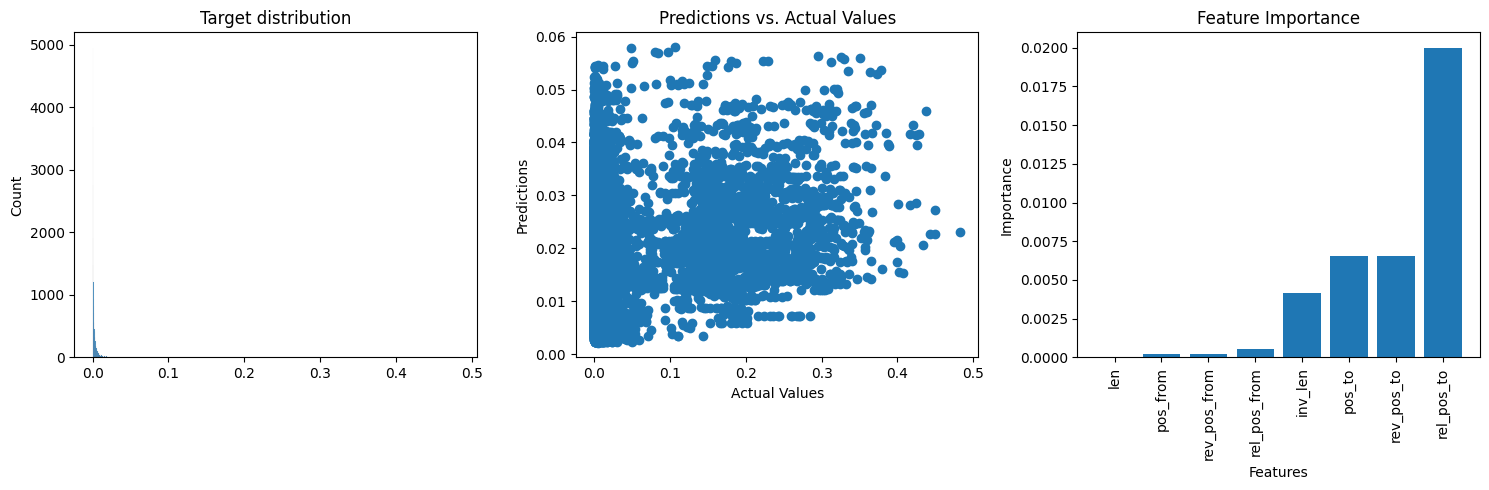

Success


In [31]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb From

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.021909555135597714
Test R2: 0.03035193404982306; Test MSE:  0.003010901597949407; Test explained_variance_score: 0.03035262888598944
Test max_error: 0.4595383015283; Test mean_absolute_percentage_error:  90.17262234514706

Predictions:
Pred = 0.004588384400853815 / 0.004588384400853815 and target = 0.0017023766413331032 / 0.0017023766413331032


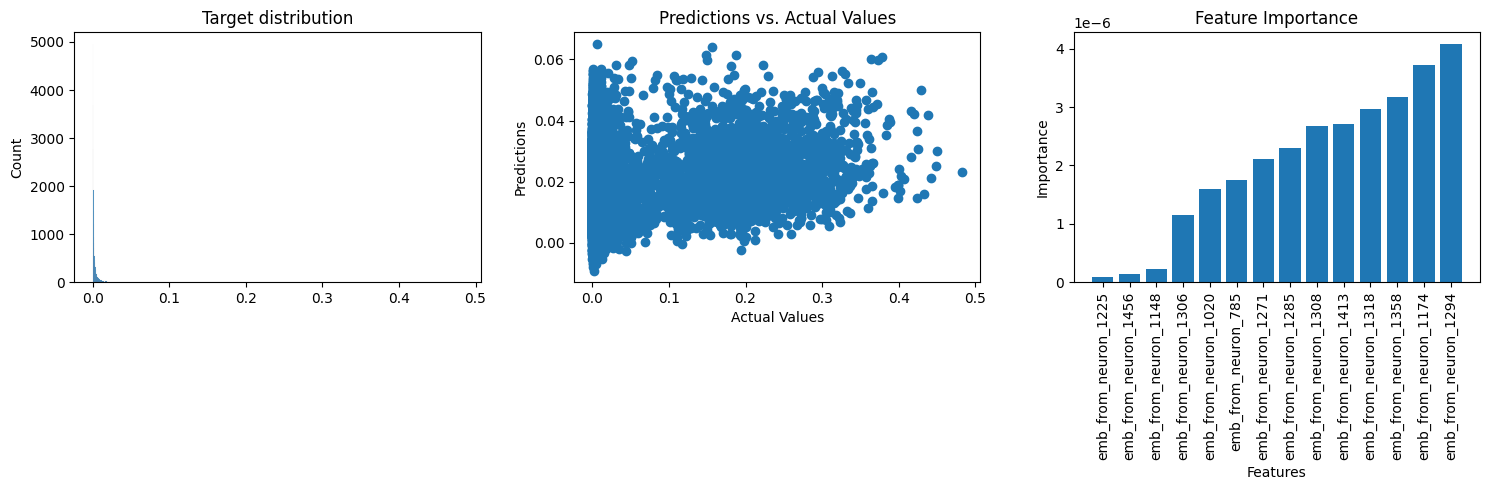

Success


In [32]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(778,1546))
data['features'] = 'emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Emb To

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.8503516666163318
Test R2: 0.8668555313684796; Test MSE:  0.0004134333965467507; Test explained_variance_score: 0.8668562169996401
Test max_error: 0.29340179996697013; Test mean_absolute_percentage_error:  30.20182355869874

Predictions:
Pred = 0.0074301309023018375 / 0.0074301309023018375 and target = 0.0026225745677948 / 0.0026225745677948


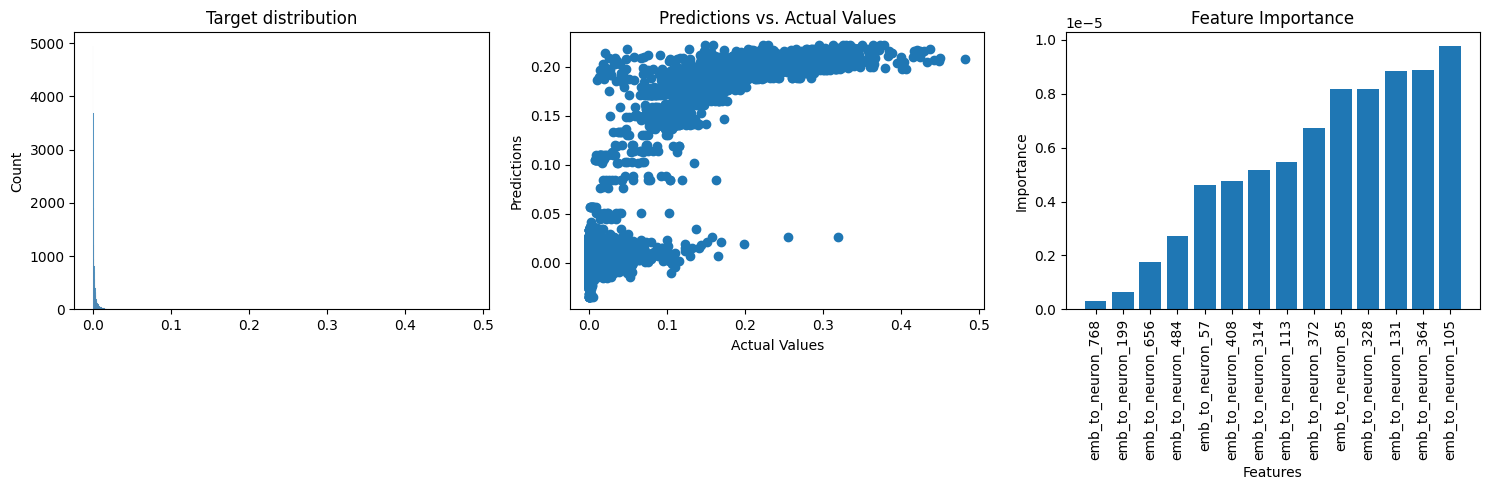

Success


In [33]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions Emb To and Emb From

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.8500565146757051
Test R2: 0.8661997377523611; Test MSE:  0.00041546973335392133; Test explained_variance_score: 0.8662004233907381
Test max_error: 0.29355508847822764; Test mean_absolute_percentage_error:  33.86419023436693

Predictions:
Pred = -0.011505146002442655 / -0.011505146002442655 and target = 0.00017055073112715036 / 0.00017055073112715036


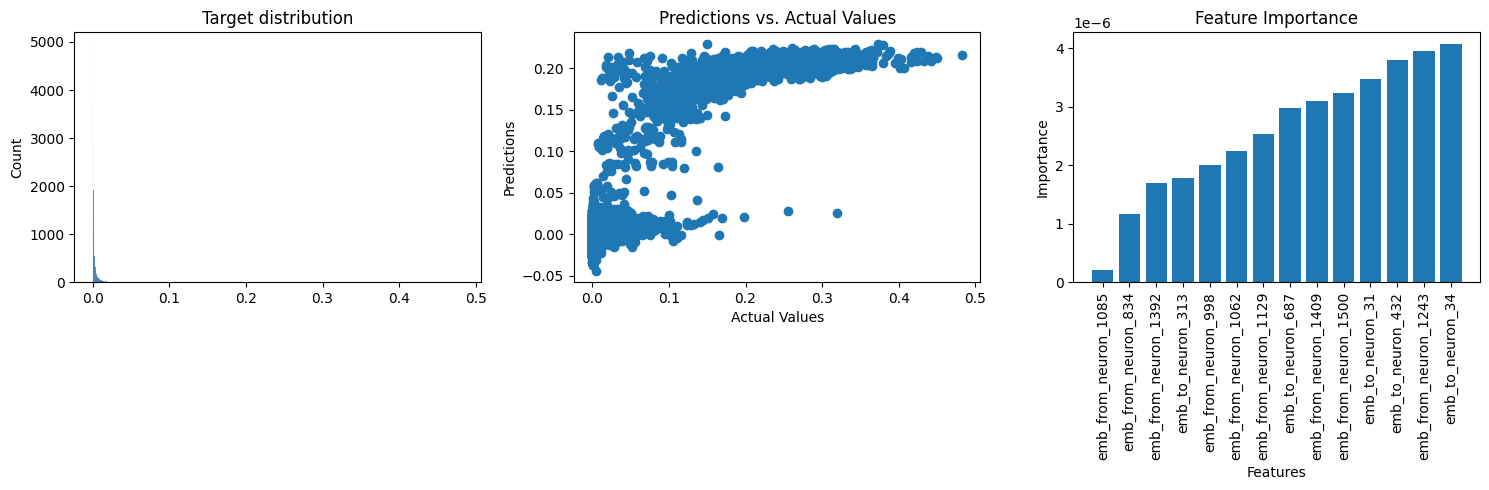

Success


In [34]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_to_neuron_{i}' for i in range(10,778)]+[f'emb_from_neuron_{i}' for i in range(778,1546)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] + list(range(10,1546))
data['features'] = 'emb_to, emb_from, pos'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions, Emb To, Special Symbols

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.851754090998784
Test R2: 0.8723600132177438; Test MSE:  0.000396341160943112; Test explained_variance_score: 0.8723606987883322
Test max_error: 0.29381919047944494; Test mean_absolute_percentage_error:  30.194147617462242

Predictions:
Pred = -0.0008906432269245278 / -0.0008906432269245278 and target = 0.026555735617876053 / 0.026555735617876053


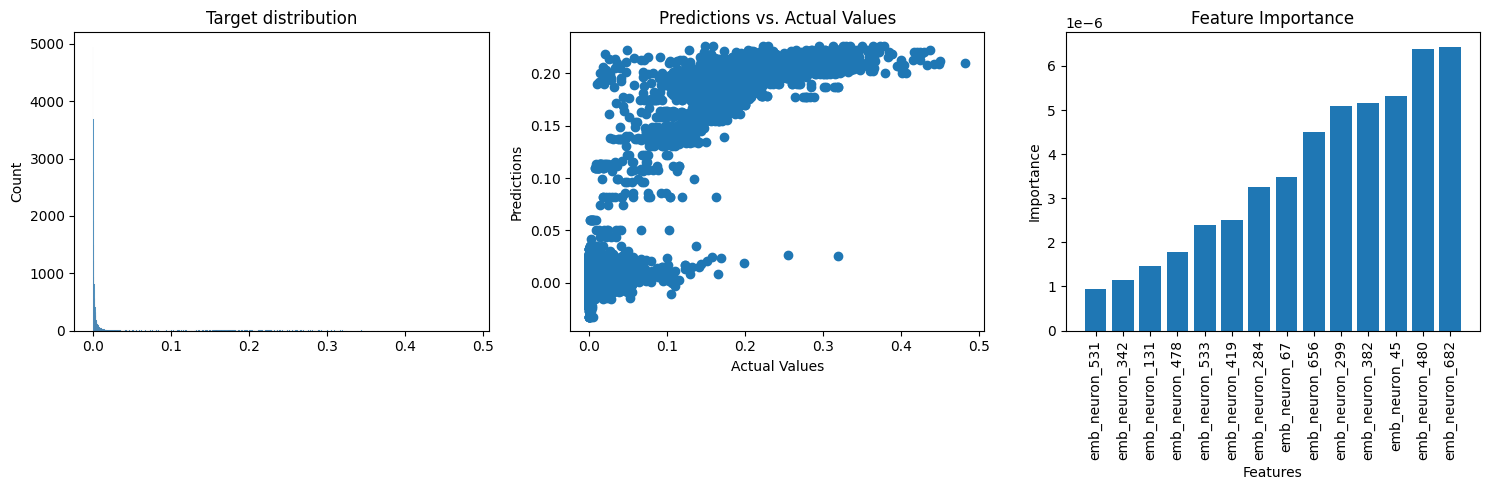

Success


In [35]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) + [f'emb_neuron_{i}' for i in range(10,778)]
 
lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(range(10,778))
data['features'] = 'emb_to, pos, st_to, st_from'

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test, feature_names)
print('Success')

### Positions and Special Symbols

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.05013705190310806
Test R2: 0.07484039748254045; Test MSE:  0.002872758295916806; Test explained_variance_score: 0.07484109182914922
Test max_error: 0.46269846242376866; Test mean_absolute_percentage_error:  81.48555442339918

Predictions:
Pred = 0.02090737660835727 / 0.02090737660835727 and target = 0.0002788241545204073 / 0.0002788241545204073


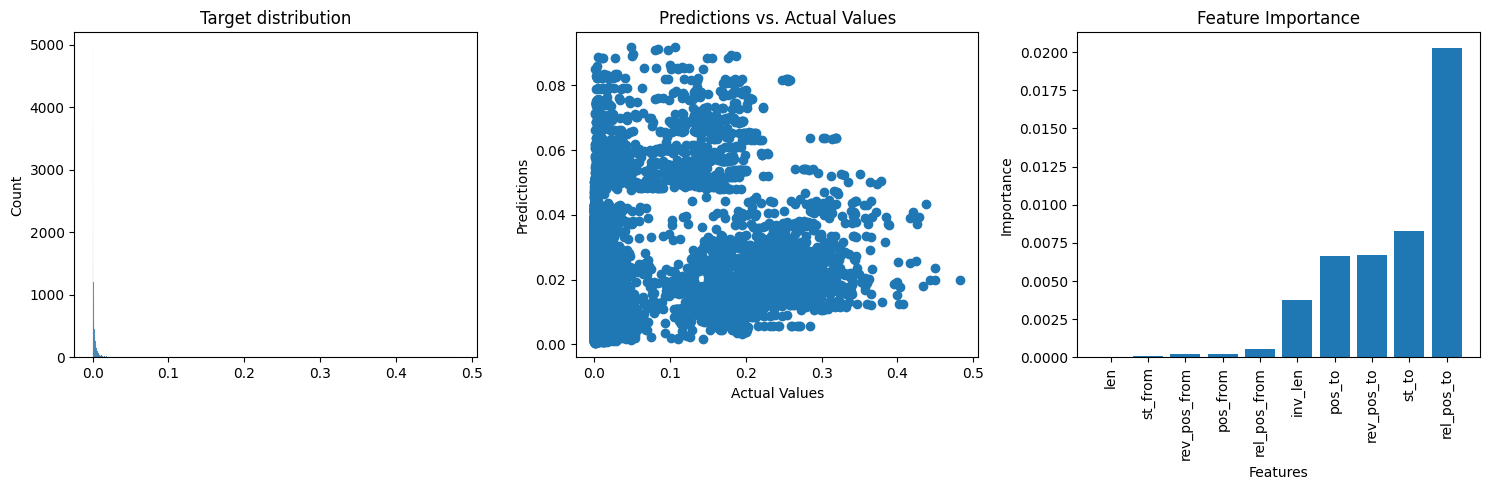

Success


In [36]:
feature_names = {'pos_from': [0], 'pos_to':[1], 'st_from': [2], 'st_to':[3], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
data['features'] = 'pos, st_to, st_from'
learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### Positions and Polynomial

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.027399245185575884
Test R2: 0.036130744974727014; Test MSE:  0.0029929575297260656; Test explained_variance_score: 0.036131439747302374
Test max_error: 0.45971492690207844; Test mean_absolute_percentage_error:  90.15276674224674

Predictions:
Pred = 0.018039394939330426 / 0.018039394939330426 and target = 5.465182039188221e-05 / 5.465182039188221e-05


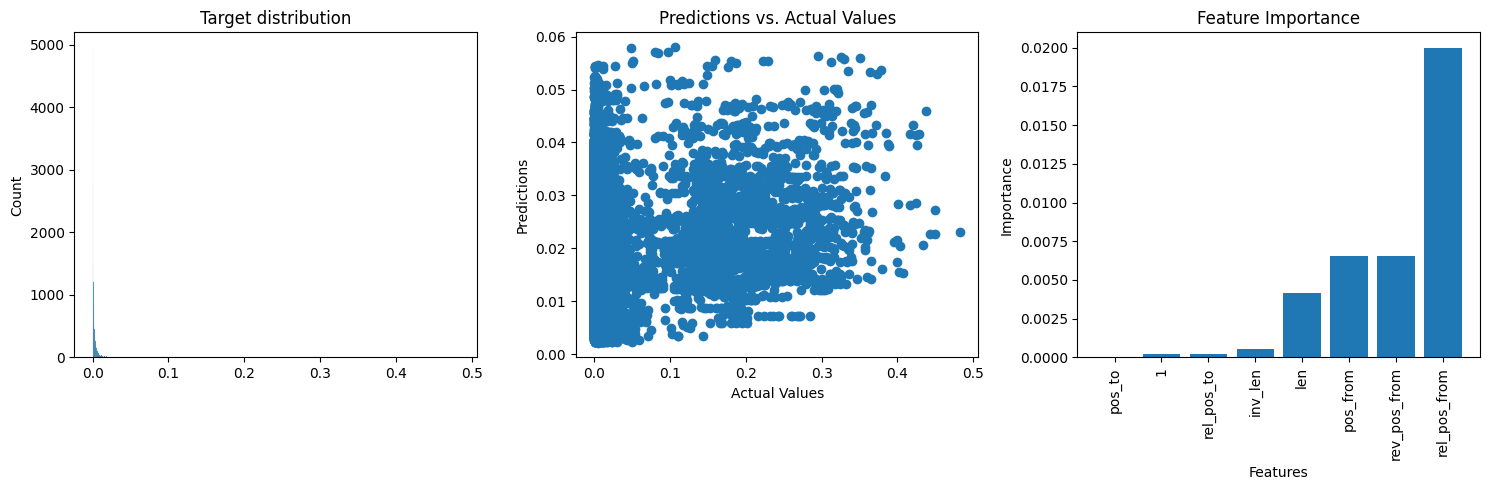

Success


In [37]:
data['features'] = 'pos, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]

lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
feature_names = poly_transform.get_feature_names_out(feature_names)

learn(pipe, id_scaler, id_scaler, X_train[:, lst_features], y_train, X_test[:, lst_features], y_test,feature_names)
print('Success')

### ALL TOGETHER

Y train mean: 0.017621525
Y test mean: 0.017575433
Mean cross val R2: 0.8526526636806903
Test R2: 0.8640794275895041; Test MSE:  0.00042205361206381075; Test explained_variance_score: 0.8640795166199777
Test max_error: 0.2903197810770304; Test mean_absolute_percentage_error:  35.05655963929088

Predictions:
Pred = 0.012009502879949584 / 0.012009502879949584 and target = 0.0005683731869794428 / 0.0005683731869794428


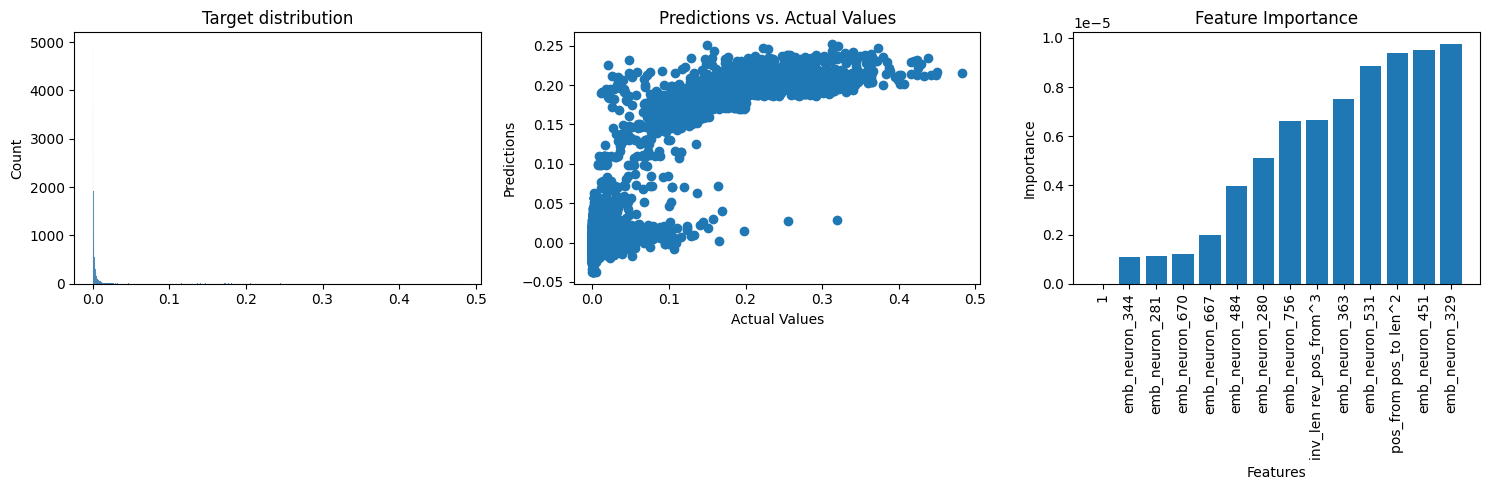

Success


In [38]:
data['features'] = 'emb_to, pos, st_to, st_from, poly'

feature_names = {'pos_from': [0], 'pos_to':[1], 'len': [4], 
                 'inv_len': [5], 'rel_pos_from': [6], 'rel_pos_to': [7],
                 'rev_pos_from': [8], 'rev_pos_to': [9]}
feature_names = list(feature_names) #+ [f'emb_neuron_{i}' for i in range(10,778)]
    
lst_features = [0, 1, 4, 5, 6, 7, 8, 9] #+ list(range(10,778))
    
poly_transform = PolynomialFeatures(degree=4)
X_train_poly = poly_transform.fit_transform(X_train[:, lst_features])
X_test_poly = poly_transform.transform(X_test[:, lst_features])
    
X_train_poly = np.concatenate((X_train_poly, X_train[:, list(range(10,778))]), axis=1)
X_test_poly = np.concatenate((X_test_poly, X_test[:, list(range(10,778))]), axis=1)
    
feature_names = list(poly_transform.get_feature_names_out(feature_names)) + [f'emb_neuron_{i}' for i in range(10,778)]
    
learn(pipe, id_scaler, id_scaler, X_train_poly, y_train, X_test_poly, y_test, feature_names)
print('Success')

In [279]:
metrics.to_csv(f'linear_metrics_report{datetime.date.today()}.csv')

# Results

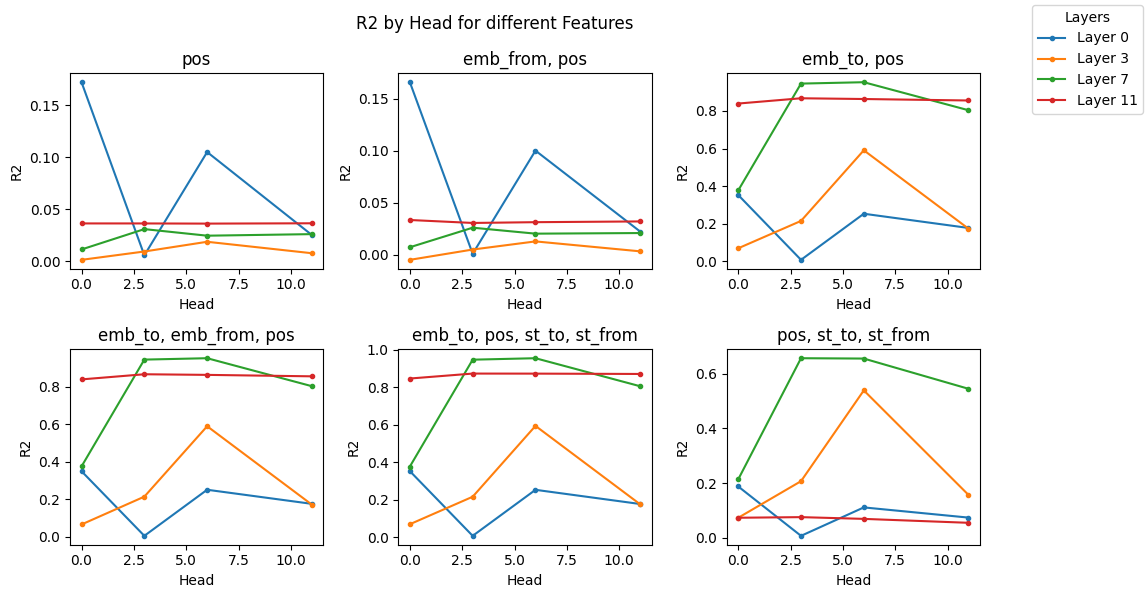

In [266]:
fig, a = plt.subplots(2, 3, figsize = (10, 6))
fig.suptitle('R2 by Head for different Features')
for i, features in enumerate(metrics['features'].unique()[:-2]):
    plt.subplot(2, 3, i+1)
    if i == 0:
        l = []
    for layer, group_data in metrics[metrics['features'] == features].sort_values(by='head').groupby('layer'):
        line, = plt.plot(group_data['head'], group_data['r2'], label=f'Layer {layer}', marker='.', linestyle='-')
        plt.xlabel('Head')
        plt.ylabel('R2')
        plt.title(features)
        if i == 0:
            l.append(line)
        
legend = fig.legend(handles=l)
legend.set_bbox_to_anchor((1.15, 1))
legend.set_title("Layers", prop={"size": 10})  # Set legend title and its size

plt.tight_layout()

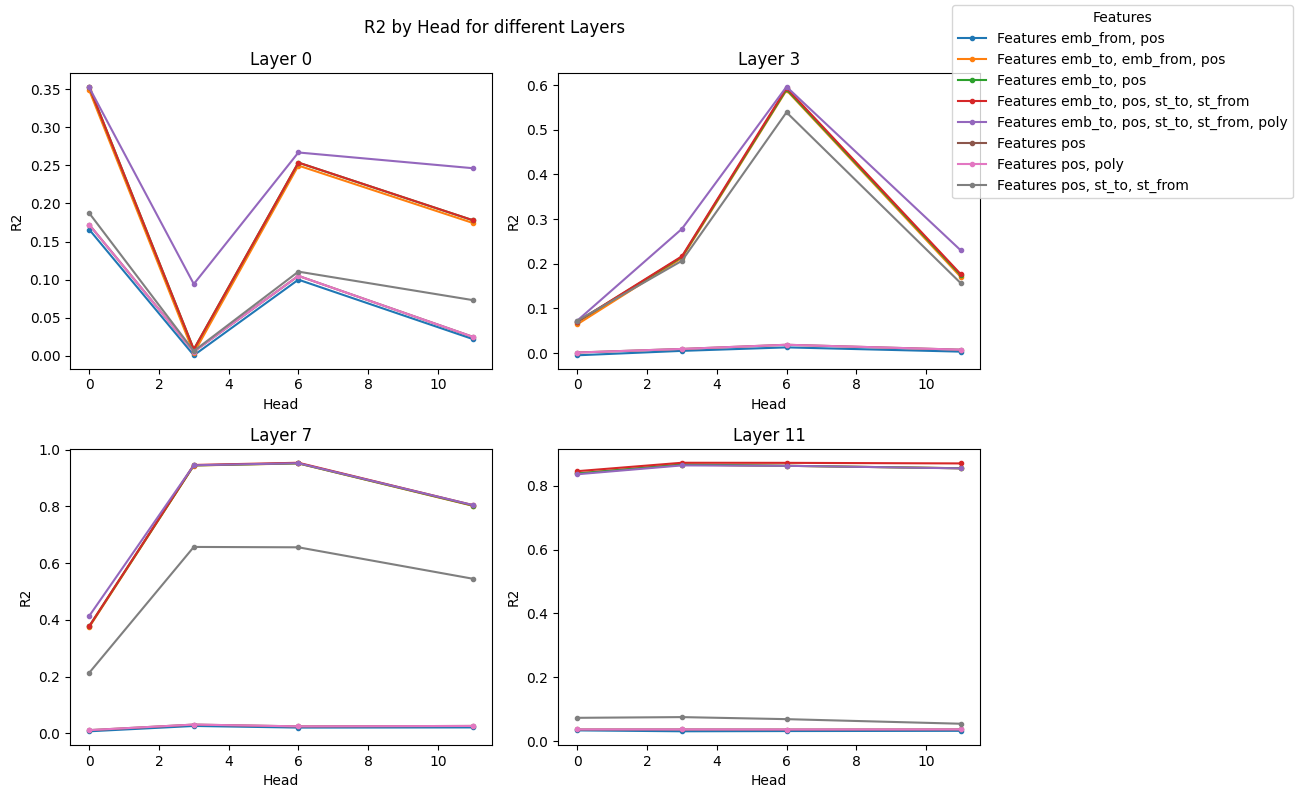

In [264]:
fig, a = plt.subplots(2,2, figsize = (10, 8))
fig.suptitle('R2 by Head for different Layers')
for i, layer in enumerate(metrics['layer'].unique()):
    plt.subplot(2,2, i+1)
    if i == 0:
        l = []
    for features, group_data in metrics[metrics['layer'] == layer].sort_values(by='features').sort_values(by='head').groupby('features'):
        line, = plt.plot(group_data['head'], group_data['r2'], label=f'Features {features}', marker='.', linestyle='-')
        plt.xlabel('Head')
        plt.ylabel('R2')
        # plt.legend()
        plt.title(f'Layer {layer}')
        if i == 0:
            l.append(line)
        
legend = fig.legend(handles=l)
legend.set_bbox_to_anchor((1.3, 1))
legend.set_title("Features", prop={"size": 10})  # Set legend title and its size

plt.tight_layout()

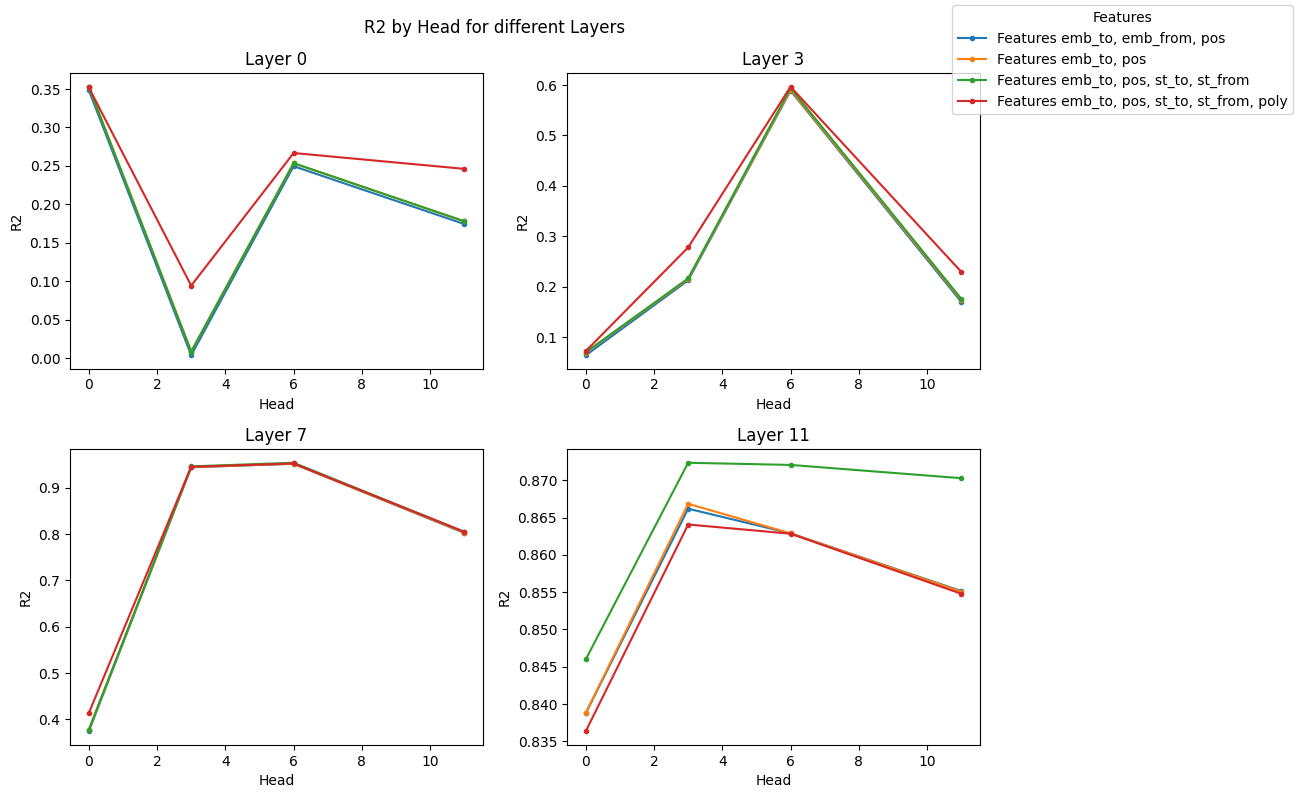

In [253]:
fig, a = plt.subplots(2,2, figsize = (10, 8))
fig.suptitle('R2 by Head for different Layers')
for i, layer in enumerate(metrics['layer'].unique()):
    plt.subplot(2,2, i+1)
    if i == 0:
        l = []
    for features, group_data in metrics[metrics['layer'] == layer].sort_values(by='features').sort_values(by='head').groupby('features'):
        if 'emb_to' in features:
            line, = plt.plot(group_data['head'], group_data['r2'], label=f'Features {features}', marker='.', linestyle='-')
            plt.xlabel('Head')
            plt.ylabel('R2')
            # plt.legend(loc = 'lower right')
            plt.title(f'Layer {layer}')
            if i == 0:
                l.append(line)
        
legend = fig.legend(handles=l)
legend.set_bbox_to_anchor((1.3, 1))
legend.set_title("Features", prop={"size": 10})  # Set legend title and its size

plt.tight_layout()

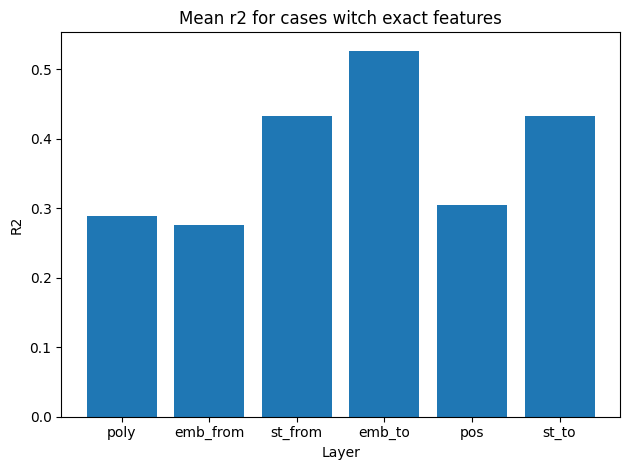

In [278]:

all_features = list(set(', '.join(metrics['features']).split(', ')))
plt.bar(all_features, [metrics[metrics['features'].str.contains(i)]['r2'].mean() for i in all_features])
plt.xlabel('Layer')
plt.ylabel('R2')
plt.title('Mean r2 for cases witch exact features')

plt.tight_layout()

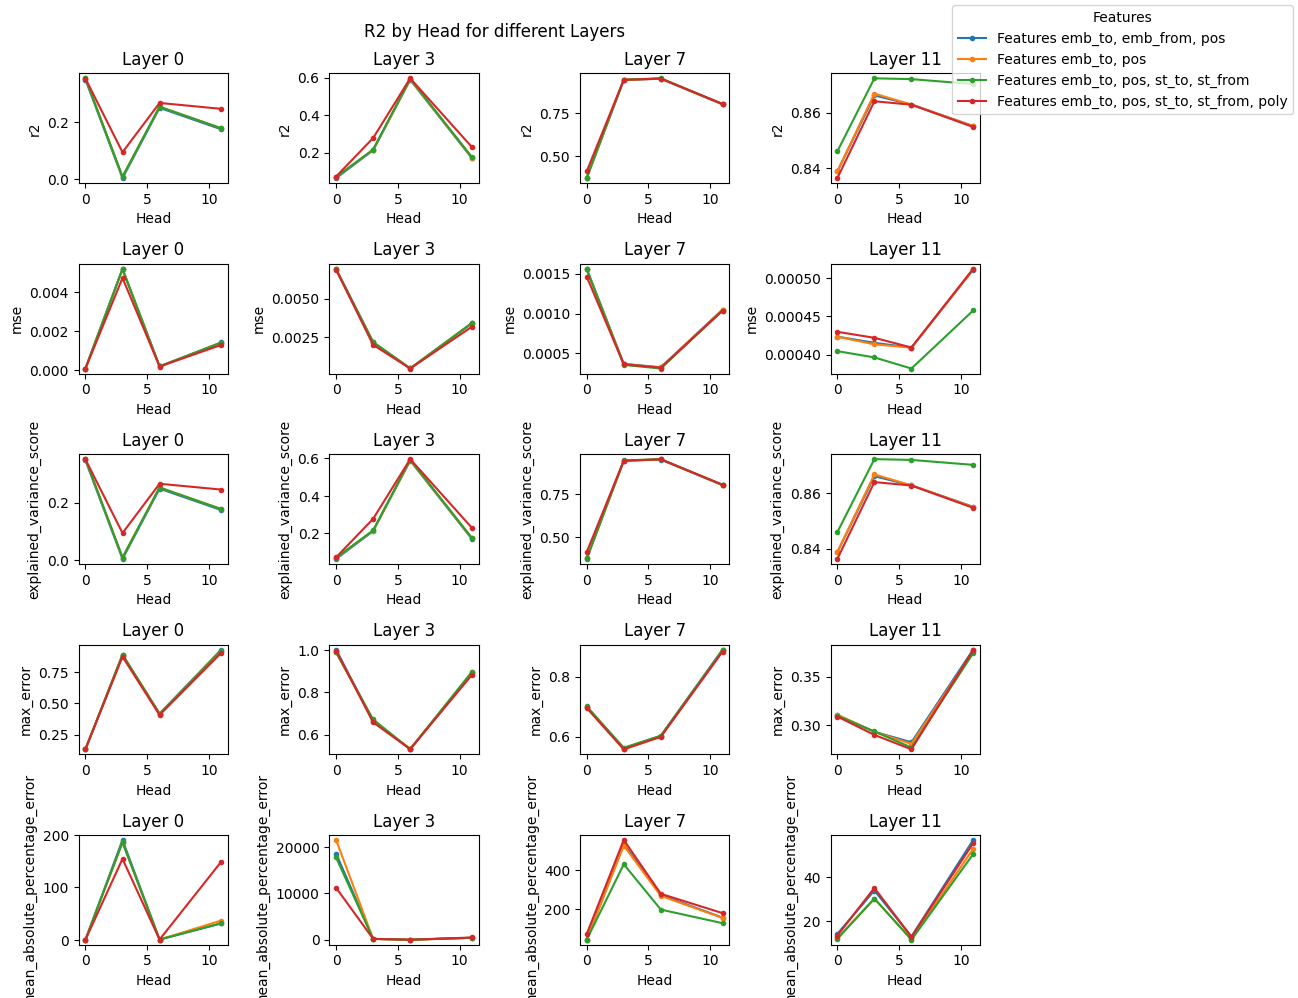

In [290]:
fig, a = plt.subplots(5,4, figsize = (10, 10))
fig.suptitle('R2 by Head for different Layers')
mtrcs = ['r2', 'mse', 'explained_variance_score', 'max_error', 'mean_absolute_percentage_error']
for j, m in enumerate(mtrcs):
    for i, layer in enumerate(metrics['layer'].unique()):
        plt.subplot(5,4, j*4+i+1)
        if i == 0:
            l = []
        for features, group_data in metrics[(metrics['layer'] == layer) & (metrics['features'].str.contains('emb_to'))].sort_values(by='features').sort_values(by='head').groupby('features'):
            line, = plt.plot(group_data['head'], group_data[m], label=f'Features {features}', marker='.', linestyle='-')
            plt.xlabel('Head')
            plt.ylabel(m)
            # plt.legend()
            plt.title(f'Layer {layer}')
            if i == 0:
                l.append(line)
        
legend = fig.legend(handles=l)
legend.set_bbox_to_anchor((1.3, 1))
legend.set_title("Features", prop={"size": 10})  # Set legend title and its size

plt.tight_layout()